# NHLPA Salary Predictions
## By Kyle Dufrane

# Business Understanding

### Our stakeholder is the NHLPA (National Hockey League Players Association). Over the long history of the NHL there have been a total of five "lockouts" or player strikes regarding pay. The purpose for this project is to devolop a machine learning model that will predict players salaries, excluding goalies (as this will require another model due to stats), based on prior performance. The NHLPA will be able to use to model, moving forward, to negotiate player contract prices against the NHL. 

In [1]:
# Import needed libraries

from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
import pickle

sns.set_style("darkgrid")
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

######################################################################

import statsmodels.api as sm
from statsmodels.formula.api import ols

from itertools import combinations

from sklearn.linear_model import LinearRegression, OrthogonalMatchingPursuit
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import ExtraTreesRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline

from lazypredict.Supervised import LazyRegressor

from xgboost import XGBRegressor

######################################################################

# All functions are stored in the src folder attached to this repo
import sys
sys.path.insert(0, 'src/')
from modeling import *

######################################################################

import warnings
warnings.filterwarnings('ignore')

# Modeling

## First Simple Model

### We'll start by importing our saved csv and renaming our year columns. We need to rename our columns going forward in order for the OLS model to perform correctly.

In [2]:
df = pd.read_csv('data/cleaned_players_df.csv')
df.head()

,Unnamed: 0,type,birthDate,currentAge,birthCity,birthStateProvince,birthCountry,nationality,height,weight,active,alternateCaptain,captain,rookie,shootsCatches,rosterStatus,timeOnIce20,assists20,goals20,pim20,shots20,games20,hits20,powerPlayGoals20,powerPlayPoints20,powerPlayTimeOnIce20,evenTimeOnIce20,penaltyMinutes20,faceOffPct20,shotPct20,gameWinningGoals20,overTimeGoals20,shortHandedGoals20,shortHandedPoints20,shortHandedTimeOnIce20,blocked20,plusMinus20,points20,shifts20,timeOnIcePerGame20,evenTimeOnIcePerGame20,shortHandedTimeOnIcePerGame20,powerPlayTimeOnIcePerGame20,timeOnIce19,assists19,goals19,pim19,shots19,games19,hits19,powerPlayGoals19,powerPlayPoints19,powerPlayTimeOnIce19,evenTimeOnIce19,penaltyMinutes19,faceOffPct19,shotPct19,gameWinningGoals19,overTimeGoals19,shortHandedGoals19,shortHandedPoints19,shortHandedTimeOnIce19,blocked19,plusMinus19,points19,shifts19,timeOnIcePerGame19,evenTimeOnIcePerGame19,shortHandedTimeOnIcePerGame19,powerPlayTimeOnIcePerGame19,timeOnIce18,assists18,goals18,pim18,shots18,games18,hits18,powerPlayGoals18,powerPlayPoints18,powerPlayTimeOnIce18,evenTimeOnIce18,penaltyMinutes18,faceOffPct18,shotPct18,gameWinningGoals18,overTimeGoals18,shortHandedGoals18,shortHandedPoints18,shortHandedTimeOnIce18,blocked18,plusMinus18,points18,shifts18,timeOnIcePerGame18,evenTimeOnIcePerGame18,shortHandedTimeOnIcePerGame18,powerPlayTimeOnIcePerGame18,timeOnIce17,assists17,goals17,pim17,shots17,games17,hits17,powerPlayGoals17,powerPlayPoints17,powerPlayTimeOnIce17,evenTimeOnIce17,penaltyMinutes17,faceOffPct17,shotPct17,gameWinningGoals17,overTimeGoals17,shortHandedGoals17,shortHandedPoints17,shortHandedTimeOnIce17,blocked17,plusMinus17,points17,shifts17,timeOnIcePerGame17,evenTimeOnIcePerGame17,shortHandedTimeOnIcePerGame17,powerPlayTimeOnIcePerGame17,2014-15,2015-16,2016-17,2017-18,2018-19,2019-20,2020-21,2013-14,2011-12,2012-13,2010-11
0,0,Defenseman,1989,32,Toronto,ON,CAN,CAN,72,210,True,True,False,False,R,Y,1504.25,11.00,7.00,79.00,151.00,68.00,88.00,2.00,6.00,160.14,1232.41,79.00,0.00,4.60,3.00,0.00,0.00,0.00,111.30,90.00,-21.00,18.00,1883.00,22.07,18.07,1.38,2.21,1427.51,22.00,9.00,60.00,168.00,63.00,56.00,2.00,10.00,163.07,1166.17,60.00,0.00,5.36,1.00,0.00,1.00,1.00,98.27,75.00,5.00,31.00,1731.00,22.39,18.30,1.33,2.35,1977.24,43.00,16.00,82.00,207.00,82.00,111.00,5.00,25.00,253.23,1507.00,82.00,33.33,7.73,2.00,0.00,0.00,1.00,217.01,90.00,18.00,59.00,2323.00,24.06,18.22,2.38,3.05,1610.40,30.00,10.00,44.00,142.00,66.00,78.00,3.00,16.00,172.00,1300.43,44.00,0.00,7.04,2.00,0.00,0.00,1.00,137.57,104.00,-8.00,40.00,1860.00,24.24,19.42,2.05,2.36,7000000.00,7000000.00,11000000.00,11000000.00,10000000.00,10000000.00,8000000.00,0.00,0.00,0.00,0.00
1,1,Defenseman,1993,27,Regina,SK,CAN,CAN,73,206,True,False,False,False,L,Y,538.48,7.00,2.00,4.00,32.00,27.00,12.00,0.00,2.00,23.15,460.25,4.00,0.00,6.30,0.00,0.00,0.00,0.00,55.08,50.00,-9.00,9.00,708.00,19.57,17.03,2.02,0.51,1200.36,28.00,1.00,10.00,71.00,56.00,27.00,0.00,1.00,33.43,1025.18,10.00,0.00,1.41,0.00,0.00,0.00,0.00,141.35,93.00,20.00,29.00,1501.00,21.26,18.18,2.31,0.36,811.12,11.00,1.00,8.00,34.00,44.00,31.00,0.00,0.00,12.06,710.11,8.00,0.00,2.94,0.00,0.00,0.00,0.00,88.55,75.00,4.00,12.00,1059.00,18.26,16.08,2.01,0.16,1099.59,9.00,2.00,24.00,52.00,60.00,23.00,0.00,1.00,26.42,960.50,24.00,0.00,3.85,0.00,0.00,0.00,1.00,112.27,96.00,3.00,11.00,1463.00,18.19,16.00,1.52,0.26,0.00,0.00,0.00,0.00,0.00,4500000.00,4700000.00,0.00,0.00,0.00,0.00
2,2,Defenseman,1994,26,Melville,SK,CAN,CAN,74,205,True,True,False,False,R,Y,1584.26,23.00,8.00,52.00,114.00,69.00,81.00,3.00,10.00,137.22,1277.50,52.00,0.00,7.00,2.00,0.00,0.00,0.00,169.14,97.00,-20.00,31.00,1924.00,22.57,18.31,2.27,1.59,1807.31,28.00,11.00,58.00,146.00,82.00,83.00,3.00,12.00,201.51,1483.03,58.00,0.00,7.53,0.00,0.00,0.00,1.00,122.37,87.00,-27.00,39.00,2155.00,22.02,18.05,1.29,2.27,1495.40,15.00,9.00,42.00,121.00,76.00,107.00,0.00,4.00,124.24,1342.30,42.00,0.00,7.44,2.00,0.00,0.00,0.00,28.46,62.00,-8.00,24.

In [3]:
df = df.rename(columns={ '2014-15': 'sal_14_15', '2015-16': 'sal_15_16',\
                         '2016-17': 'sal_16_17', '2017-18': 'sal_17_18',\
                         '2018-19': 'sal_18_19', '2019-20': 'sal_19_20',\
                        '2020-21':'sal_20_21'})
df.head()

,Unnamed: 0,type,birthDate,currentAge,birthCity,birthStateProvince,birthCountry,nationality,height,weight,active,alternateCaptain,captain,rookie,shootsCatches,rosterStatus,timeOnIce20,assists20,goals20,pim20,shots20,games20,hits20,powerPlayGoals20,powerPlayPoints20,powerPlayTimeOnIce20,evenTimeOnIce20,penaltyMinutes20,faceOffPct20,shotPct20,gameWinningGoals20,overTimeGoals20,shortHandedGoals20,shortHandedPoints20,shortHandedTimeOnIce20,blocked20,plusMinus20,points20,shifts20,timeOnIcePerGame20,evenTimeOnIcePerGame20,shortHandedTimeOnIcePerGame20,powerPlayTimeOnIcePerGame20,timeOnIce19,assists19,goals19,pim19,shots19,games19,hits19,powerPlayGoals19,powerPlayPoints19,powerPlayTimeOnIce19,evenTimeOnIce19,penaltyMinutes19,faceOffPct19,shotPct19,gameWinningGoals19,overTimeGoals19,shortHandedGoals19,shortHandedPoints19,shortHandedTimeOnIce19,blocked19,plusMinus19,points19,shifts19,timeOnIcePerGame19,evenTimeOnIcePerGame19,shortHandedTimeOnIcePerGame19,powerPlayTimeOnIcePerGame19,timeOnIce18,assists18,goals18,pim18,shots18,games18,hits18,powerPlayGoals18,powerPlayPoints18,powerPlayTimeOnIce18,evenTimeOnIce18,penaltyMinutes18,faceOffPct18,shotPct18,gameWinningGoals18,overTimeGoals18,shortHandedGoals18,shortHandedPoints18,shortHandedTimeOnIce18,blocked18,plusMinus18,points18,shifts18,timeOnIcePerGame18,evenTimeOnIcePerGame18,shortHandedTimeOnIcePerGame18,powerPlayTimeOnIcePerGame18,timeOnIce17,assists17,goals17,pim17,shots17,games17,hits17,powerPlayGoals17,powerPlayPoints17,powerPlayTimeOnIce17,evenTimeOnIce17,penaltyMinutes17,faceOffPct17,shotPct17,gameWinningGoals17,overTimeGoals17,shortHandedGoals17,shortHandedPoints17,shortHandedTimeOnIce17,blocked17,plusMinus17,points17,shifts17,timeOnIcePerGame17,evenTimeOnIcePerGame17,shortHandedTimeOnIcePerGame17,powerPlayTimeOnIcePerGame17,sal_14_15,sal_15_16,sal_16_17,sal_17_18,sal_18_19,sal_19_20,sal_20_21,2013-14,2011-12,2012-13,2010-11
0,0,Defenseman,1989,32,Toronto,ON,CAN,CAN,72,210,True,True,False,False,R,Y,1504.25,11.00,7.00,79.00,151.00,68.00,88.00,2.00,6.00,160.14,1232.41,79.00,0.00,4.60,3.00,0.00,0.00,0.00,111.30,90.00,-21.00,18.00,1883.00,22.07,18.07,1.38,2.21,1427.51,22.00,9.00,60.00,168.00,63.00,56.00,2.00,10.00,163.07,1166.17,60.00,0.00,5.36,1.00,0.00,1.00,1.00,98.27,75.00,5.00,31.00,1731.00,22.39,18.30,1.33,2.35,1977.24,43.00,16.00,82.00,207.00,82.00,111.00,5.00,25.00,253.23,1507.00,82.00,33.33,7.73,2.00,0.00,0.00,1.00,217.01,90.00,18.00,59.00,2323.00,24.06,18.22,2.38,3.05,1610.40,30.00,10.00,44.00,142.00,66.00,78.00,3.00,16.00,172.00,1300.43,44.00,0.00,7.04,2.00,0.00,0.00,1.00,137.57,104.00,-8.00,40.00,1860.00,24.24,19.42,2.05,2.36,7000000.00,7000000.00,11000000.00,11000000.00,10000000.00,10000000.00,8000000.00,0.00,0.00,0.00,0.00
1,1,Defenseman,1993,27,Regina,SK,CAN,CAN,73,206,True,False,False,False,L,Y,538.48,7.00,2.00,4.00,32.00,27.00,12.00,0.00,2.00,23.15,460.25,4.00,0.00,6.30,0.00,0.00,0.00,0.00,55.08,50.00,-9.00,9.00,708.00,19.57,17.03,2.02,0.51,1200.36,28.00,1.00,10.00,71.00,56.00,27.00,0.00,1.00,33.43,1025.18,10.00,0.00,1.41,0.00,0.00,0.00,0.00,141.35,93.00,20.00,29.00,1501.00,21.26,18.18,2.31,0.36,811.12,11.00,1.00,8.00,34.00,44.00,31.00,0.00,0.00,12.06,710.11,8.00,0.00,2.94,0.00,0.00,0.00,0.00,88.55,75.00,4.00,12.00,1059.00,18.26,16.08,2.01,0.16,1099.59,9.00,2.00,24.00,52.00,60.00,23.00,0.00,1.00,26.42,960.50,24.00,0.00,3.85,0.00,0.00,0.00,1.00,112.27,96.00,3.00,11.00,1463.00,18.19,16.00,1.52,0.26,0.00,0.00,0.00,0.00,0.00,4500000.00,4700000.00,0.00,0.00,0.00,0.00
2,2,Defenseman,1994,26,Melville,SK,CAN,CAN,74,205,True,True,False,False,R,Y,1584.26,23.00,8.00,52.00,114.00,69.00,81.00,3.00,10.00,137.22,1277.50,52.00,0.00,7.00,2.00,0.00,0.00,0.00,169.14,97.00,-20.00,31.00,1924.00,22.57,18.31,2.27,1.59,1807.31,28.00,11.00,58.00,146.00,82.00,83.00,3.00,12.00,201.51,1483.03,58.00,0.00,7.53,0.00,0.00,0.00,1.00,122.37,87.00,-27.00,39.00,2155.00,22.02,18.05,1.29,2.27,1495.40,15.00,9.00,42.00,121.00,76.00,107.00,0.00,4.00,124.24,1342.30,42.00,0.00,7.44,2.00,0.00,0.00,0.00,28.46,6

In [4]:
formula = 'sal_20_21 ~ goals19'
sq_mod = sm.formula.ols(formula, df).fit()
sq_mod_summ = sq_mod.summary()
sq_mod_summ

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              sal_20_21   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     240.1
Date:                Tue, 21 Sep 2021   Prob (F-statistic):           4.23e-43
Time:                        13:16:46   Log-Likelihood:                -6701.9
No. Observations:                 419   AIC:                         1.341e+04
Df Residuals:                     417   BIC:                         1.342e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.209e+06    1.6e+05      7.545      0.000    8.94e+05    1.52e+06
goals19     1.561e+05   1.01e+04     15.496      0.000    1.36e+05    1.76e+05
==============================================================================
Omnibus:                       91.353   Durbin-Watson:                   1.864
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              188.984
Skew:                           1.155   Prob(JB):                     9.18e-42
Kurtosis:                       5.343   Cond. No.                         24.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Our R-squared value is 0.365 which is rather low. Hopefully we can improve upon this below.

#### Now, we will identify our categorical columns which will be OneHotEncoded during our modeling. 

In [5]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
df_cat_cols = ['type', 'birthCity', 'birthStateProvince', 'birthCountry',\
               'alternateCaptain', 'captain', 'rookie', 'shootsCatches',\
               'rosterStatus', 'nationality', 'active']
df_no_cats = df.drop(df_cat_cols, axis=1)
df_no_cats.head()

,birthDate,currentAge,height,weight,timeOnIce20,assists20,goals20,pim20,shots20,games20,hits20,powerPlayGoals20,powerPlayPoints20,powerPlayTimeOnIce20,evenTimeOnIce20,penaltyMinutes20,faceOffPct20,shotPct20,gameWinningGoals20,overTimeGoals20,shortHandedGoals20,shortHandedPoints20,shortHandedTimeOnIce20,blocked20,plusMinus20,points20,shifts20,timeOnIcePerGame20,evenTimeOnIcePerGame20,shortHandedTimeOnIcePerGame20,powerPlayTimeOnIcePerGame20,timeOnIce19,assists19,goals19,pim19,shots19,games19,hits19,powerPlayGoals19,powerPlayPoints19,powerPlayTimeOnIce19,evenTimeOnIce19,penaltyMinutes19,faceOffPct19,shotPct19,gameWinningGoals19,overTimeGoals19,shortHandedGoals19,shortHandedPoints19,shortHandedTimeOnIce19,blocked19,plusMinus19,points19,shifts19,timeOnIcePerGame19,evenTimeOnIcePerGame19,shortHandedTimeOnIcePerGame19,powerPlayTimeOnIcePerGame19,timeOnIce18,assists18,goals18,pim18,shots18,games18,hits18,powerPlayGoals18,powerPlayPoints18,powerPlayTimeOnIce18,evenTimeOnIce18,penaltyMinutes18,faceOffPct18,shotPct18,gameWinningGoals18,overTimeGoals18,shortHandedGoals18,shortHandedPoints18,shortHandedTimeOnIce18,blocked18,plusMinus18,points18,shifts18,timeOnIcePerGame18,evenTimeOnIcePerGame18,shortHandedTimeOnIcePerGame18,powerPlayTimeOnIcePerGame18,timeOnIce17,assists17,goals17,pim17,shots17,games17,hits17,powerPlayGoals17,powerPlayPoints17,powerPlayTimeOnIce17,evenTimeOnIce17,penaltyMinutes17,faceOffPct17,shotPct17,gameWinningGoals17,overTimeGoals17,shortHandedGoals17,shortHandedPoints17,shortHandedTimeOnIce17,blocked17,plusMinus17,points17,shifts17,timeOnIcePerGame17,evenTimeOnIcePerGame17,shortHandedTimeOnIcePerGame17,powerPlayTimeOnIcePerGame17,sal_14_15,sal_15_16,sal_16_17,sal_17_18,sal_18_19,sal_19_20,sal_20_21,2013-14,2011-12,2012-13,2010-11
0,1989,32,72,210,1504.25,11.00,7.00,79.00,151.00,68.00,88.00,2.00,6.00,160.14,1232.41,79.00,0.00,4.60,3.00,0.00,0.00,0.00,111.30,90.00,-21.00,18.00,1883.00,22.07,18.07,1.38,2.21,1427.51,22.00,9.00,60.00,168.00,63.00,56.00,2.00,10.00,163.07,1166.17,60.00,0.00,5.36,1.00,0.00,1.00,1.00,98.27,75.00,5.00,31.00,1731.00,22.39,18.30,1.33,2.35,1977.24,43.00,16.00,82.00,207.00,82.00,111.00,5.00,25.00,253.23,1507.00,82.00,33.33,7.73,2.00,0.00,0.00,1.00,217.01,90.00,18.00,59.00,2323.00,24.06,18.22,2.38,3.05,1610.40,30.00,10.00,44.00,142.00,66.00,78.00,3.00,16.00,172.00,1300.43,44.00,0.00,7.04,2.00,0.00,0.00,1.00,137.57,104.00,-8.00,40.00,1860.00,24.24,19.42,2.05,2.36,7000000.00,7000000.00,11000000.00,11000000.00,10000000.00,10000000.00,8000000.00,0.00,0.00,0.00,0.00
1,1993,27,73,206,538.48,7.00,2.00,4.00,32.00,27.00,12.00,0.00,2.00,23.15,460.25,4.00,0.00,6.30,0.00,0.00,0.00,0.00,55.08,50.00,-9.00,9.00,708.00,19.57,17.03,2.02,0.51,1200.36,28.00,1.00,10.00,71.00,56.00,27.00,0.00,1.00,33.43,1025.18,10.00,0.00,1.41,0.00,0.00,0.00,0.00,141.35,93.00,20.00,29.00,1501.00,21.26,18.18,2.31,0.36,811.12,11.00,1.00,8.00,34.00,44.00,31.00,0.00,0.00,12.06,710.11,8.00,0.00,2.94,0.00,0.00,0.00,0.00,88.55,75.00,4.00,12.00,1059.00,18.26,16.08,2.01,0.16,1099.59,9.00,2.00,24.00,52.00,60.00,23.00,0.00,1.00,26.42,960.50,24.00,0.00,3.85,0.00,0.00,0.00,1.00,112.27,96.00,3.00,11.00,1463.00,18.19,16.00,1.52,0.26,0.00,0.00,0.00,0.00,0.00,4500000.00,4700000.00,0.00,0.00,0.00,0.00
2,1994,26,74,205,1584.26,23.00,8.00,52.00,114.00,69.00,81.00,3.00,10.00,137.22,1277.50,52.00,0.00,7.00,2.00,0.00,0.00,0.00,169.14,97.00,-20.00,31.00,1924.00,22.57,18.31,2.27,1.59,1807.31,28.00,11.00,58.00,146.00,82.00,83.00,3.00,12.00,201.51,1483.03,58.00,0.00,7.53,0.00,0.00,0.00,1.00,122.37,87.00,-27.00,39.00,2155.00,22.02,18.05,1.29,2.27,1495.40,15.00,9.00,42.00,121.00,76.00,107.00,0.00,4.00,124.24,1342.30,42.00,0.00,7.44,2.00,0.00,0.00,0.00,28.46,62.00,-8.00,24.00,1904.00,19.40,17.39,0.22,1.38,1628.11,28.00,3.00,58.00,125.00,80.00,79.00,0.00,13.00,181.27,1421.30,58.00,0.00,2.40,1.00,0.00,0.00,0.00,25.14,73.00,-31.00,31.00,2091.00,20.21,17.46,0.18,2.16,0.00,0.00,0.00,2500000.00,3000000.00,4675000.00,4675000.00,0.00,0.00,0.00,0.00
3,1994,27,71,192,417.53,

#### Prior to building our Linear Regression Model we will need to verify that the assumptions are in place. First we will verify that our data is normally distributed or if we will need to incorporate some form of scaling within our model building process.

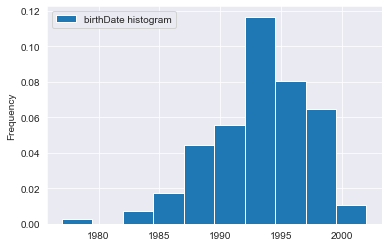

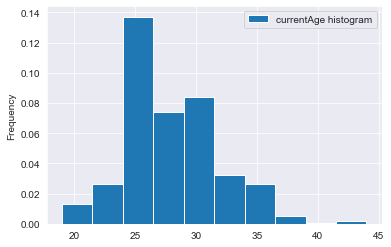

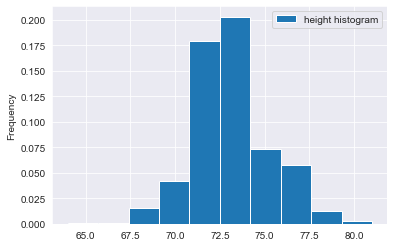

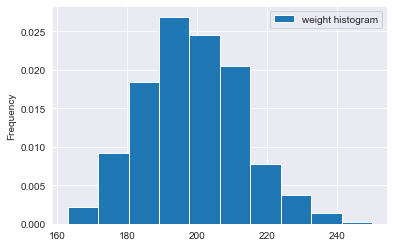

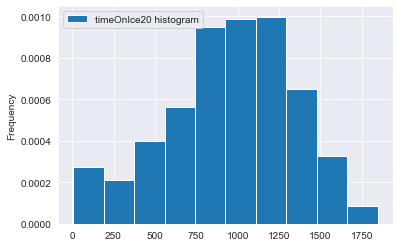

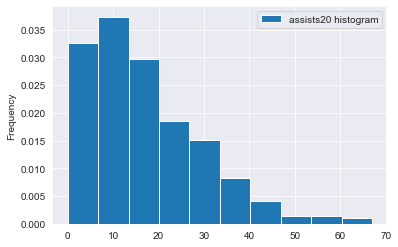

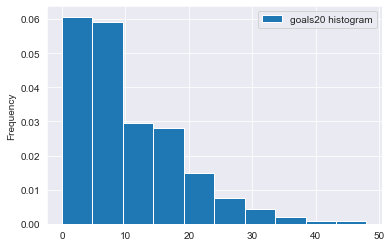

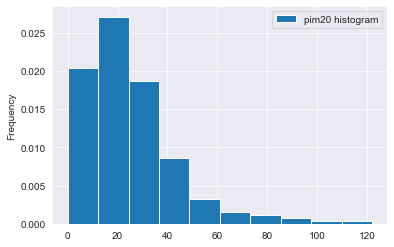

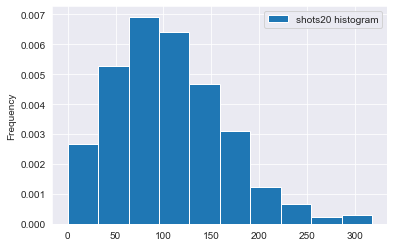

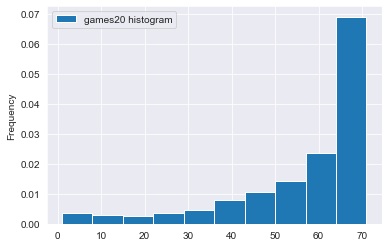

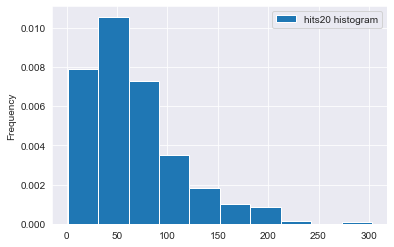

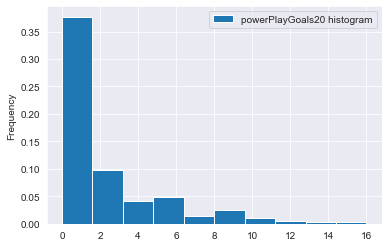

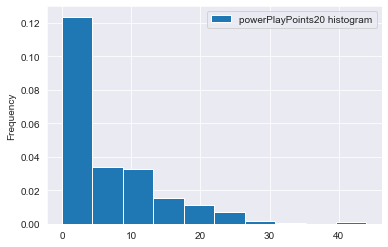

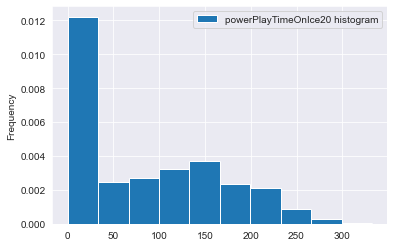

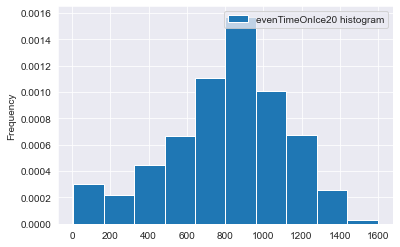

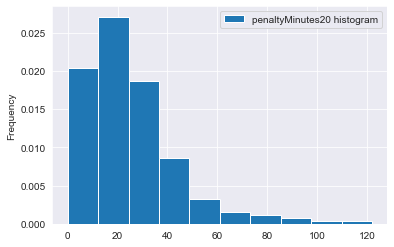

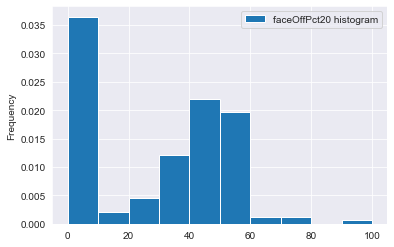

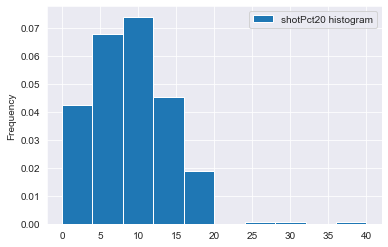

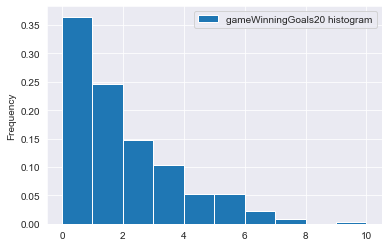

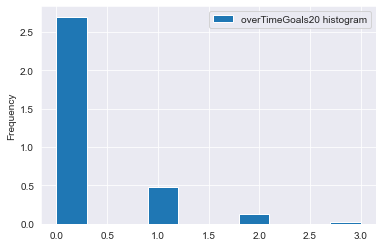

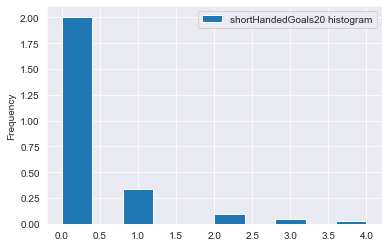

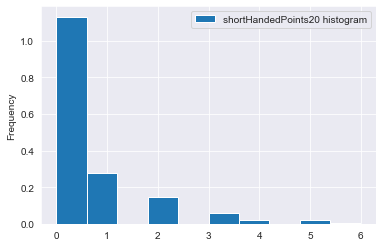

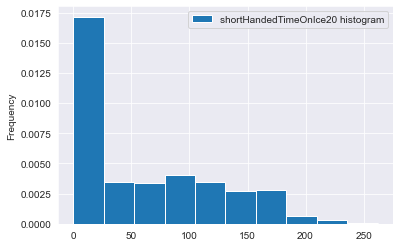

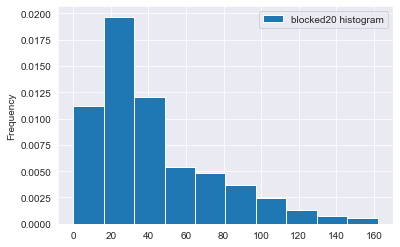

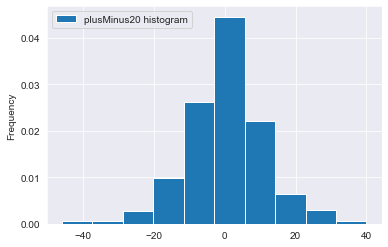

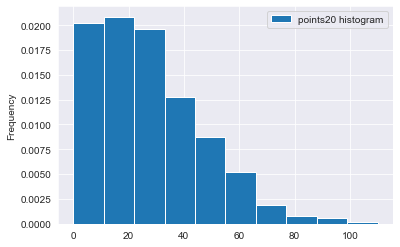

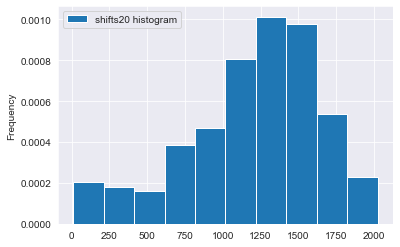

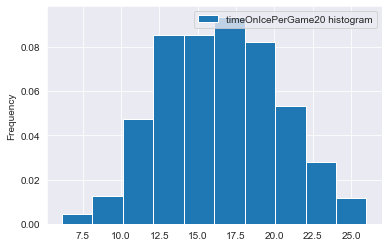

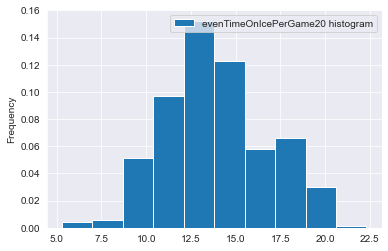

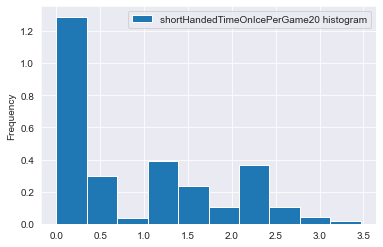

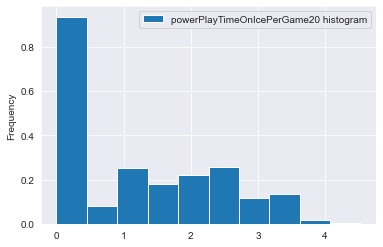

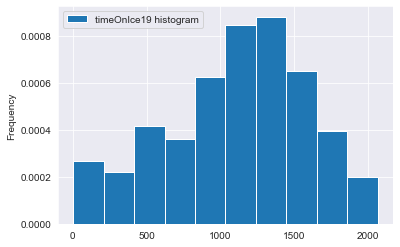

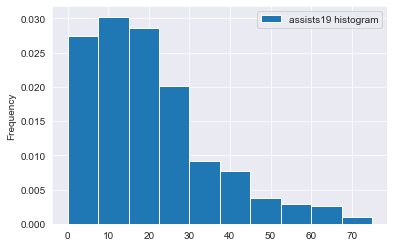

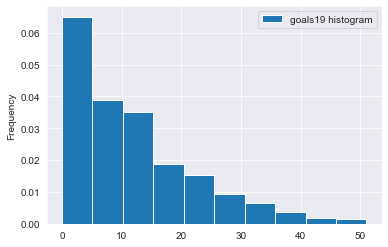

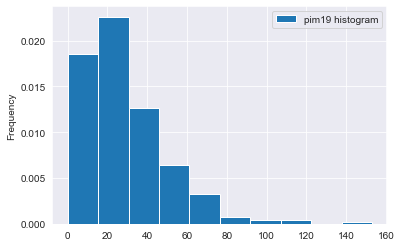

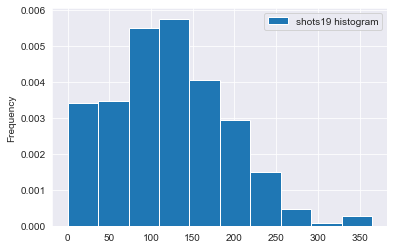

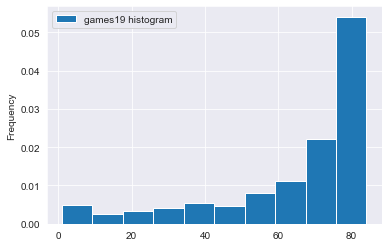

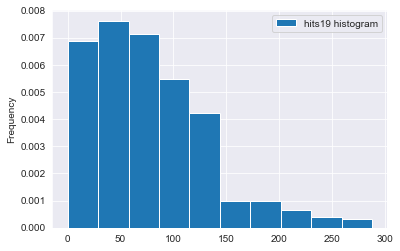

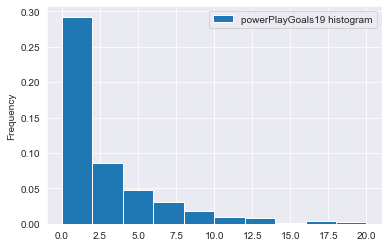

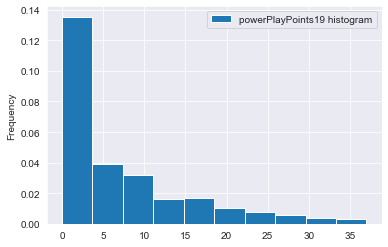

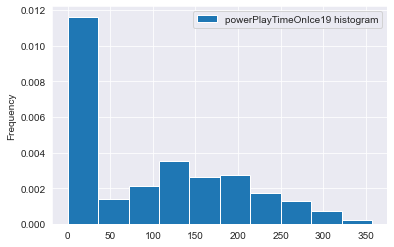

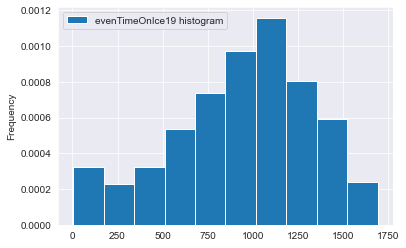

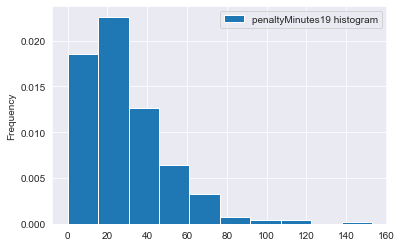

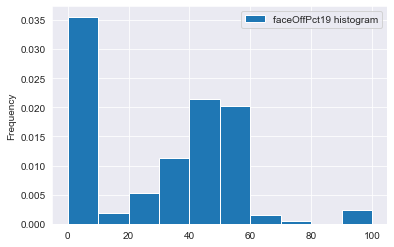

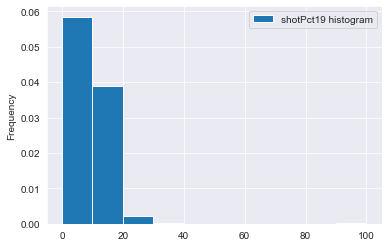

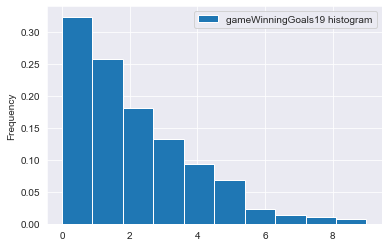

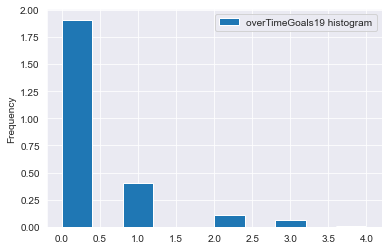

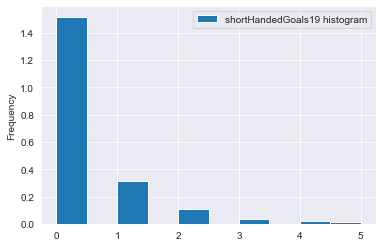

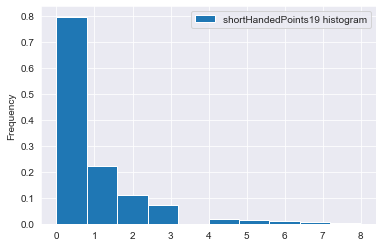

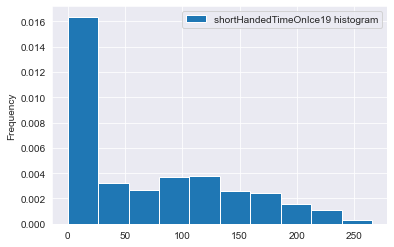

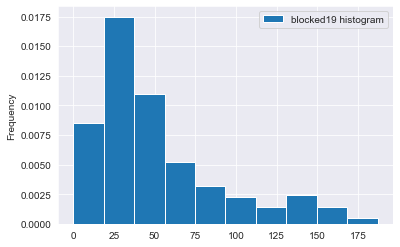

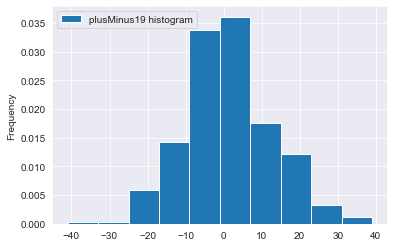

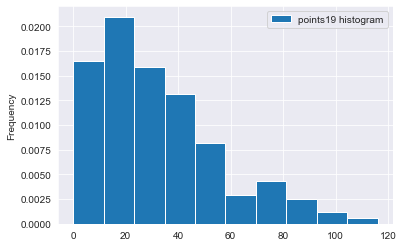

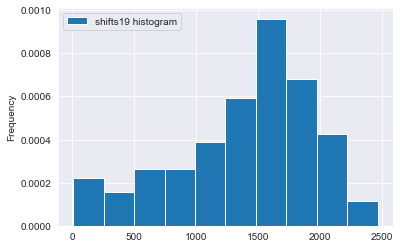

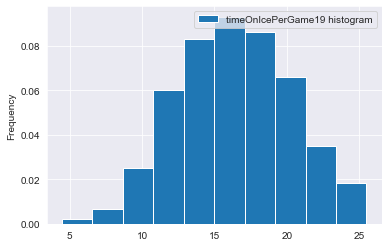

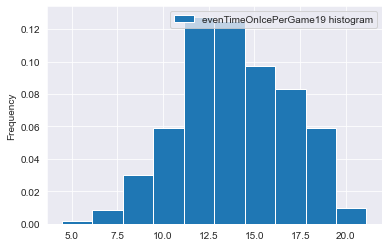

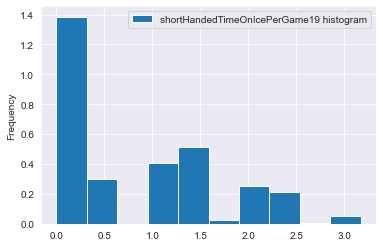

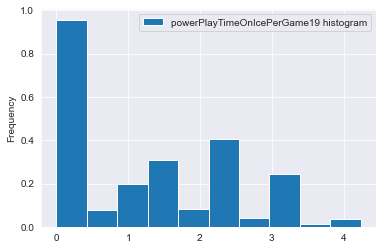

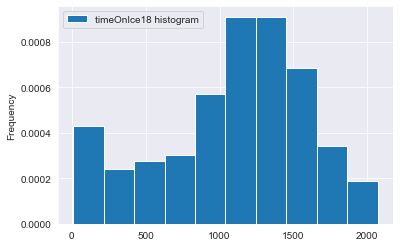

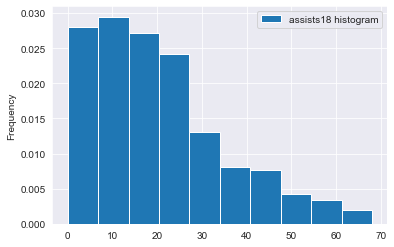

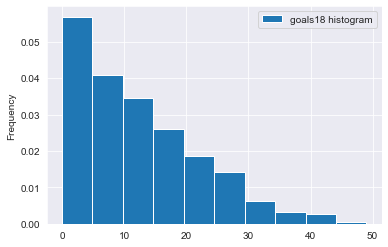

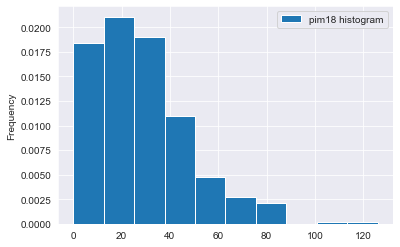

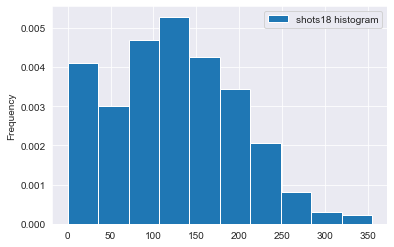

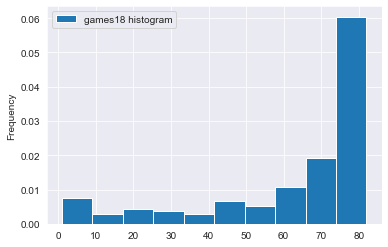

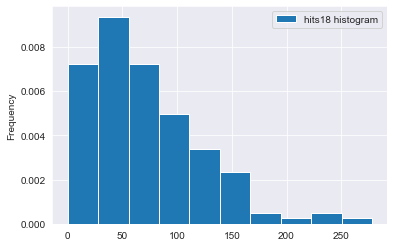

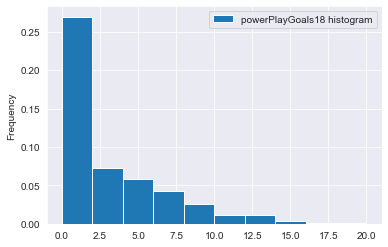

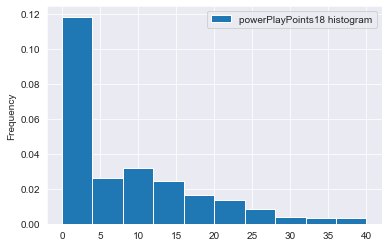

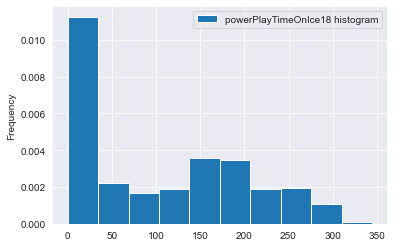

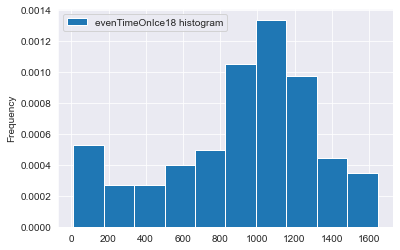

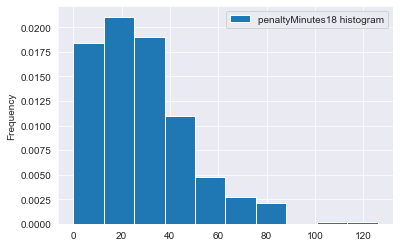

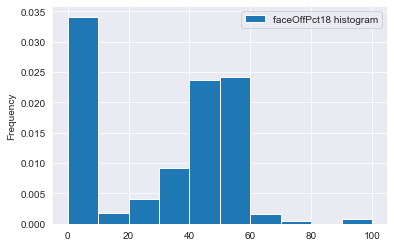

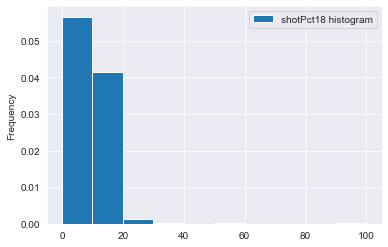

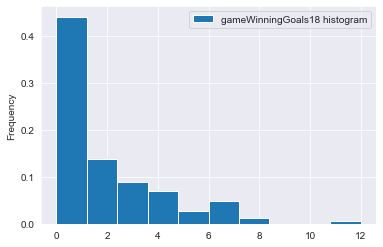

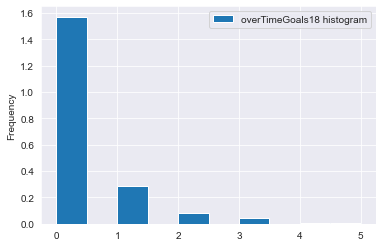

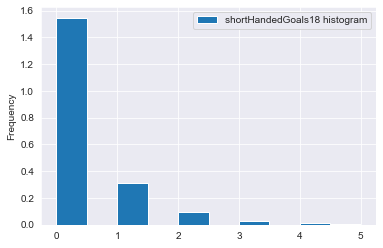

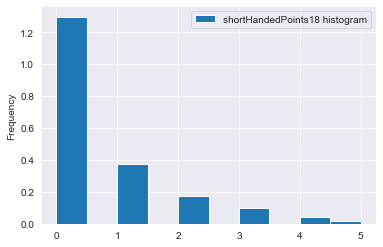

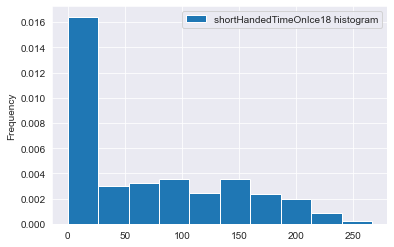

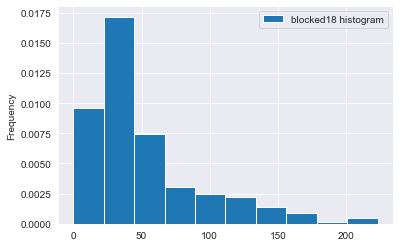

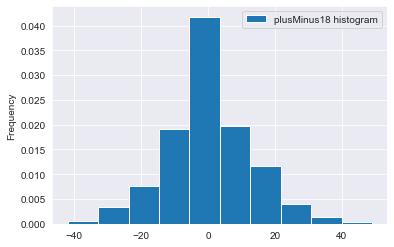

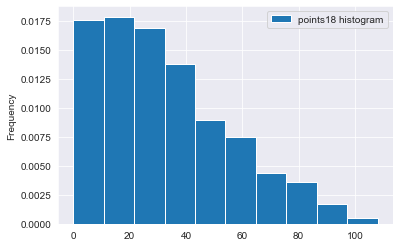

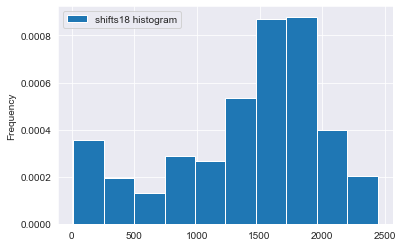

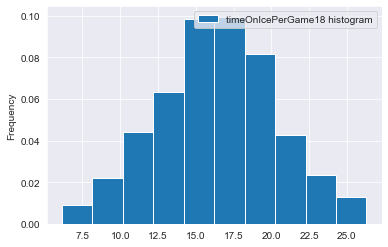

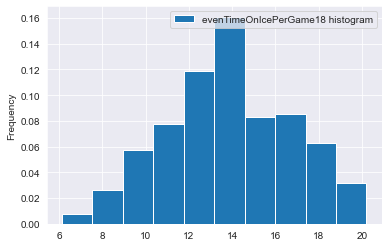

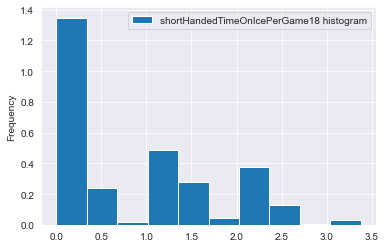

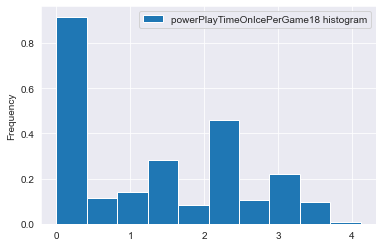

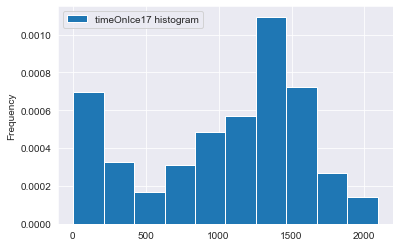

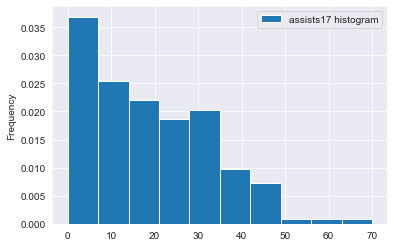

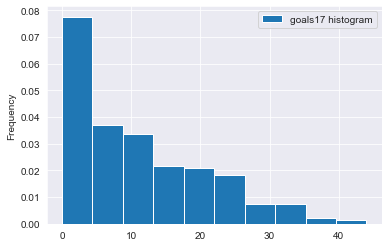

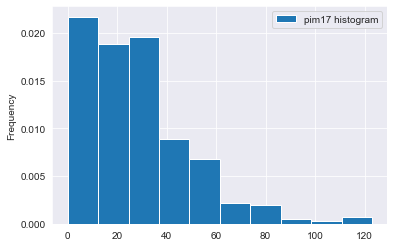

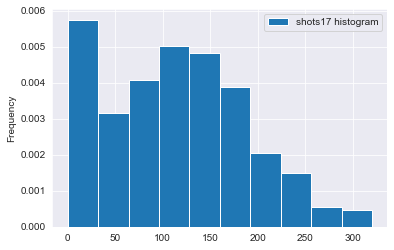

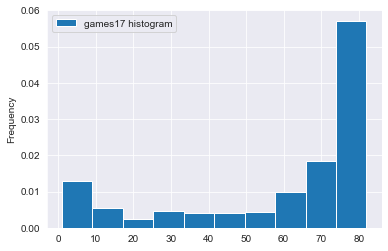

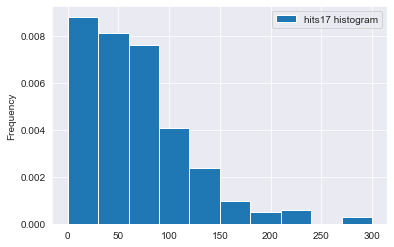

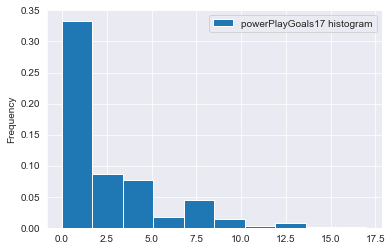

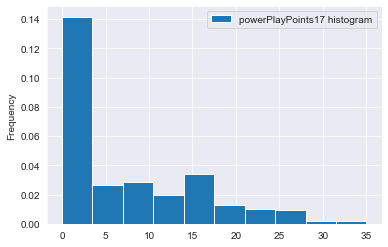

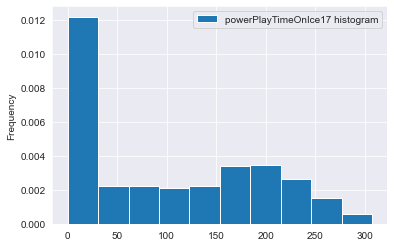

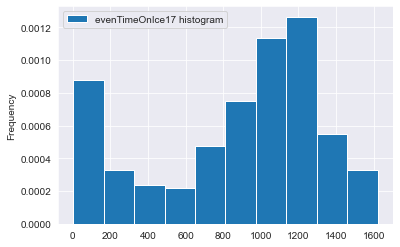

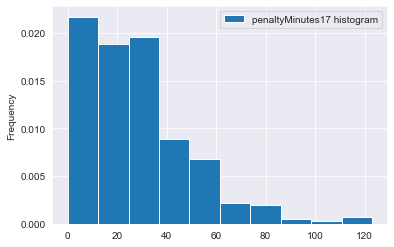

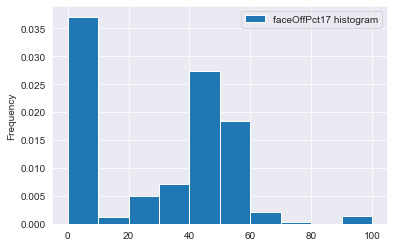

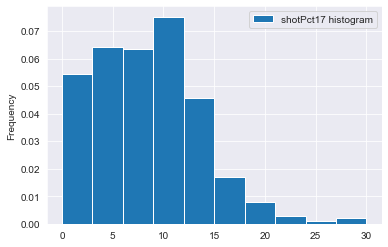

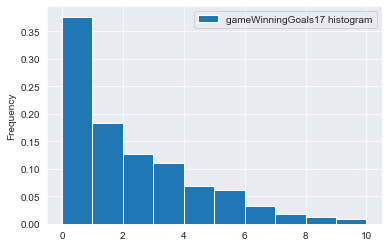

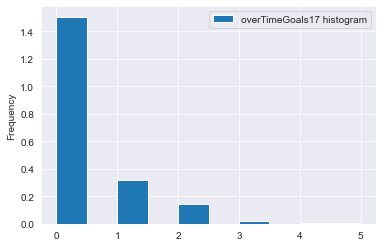

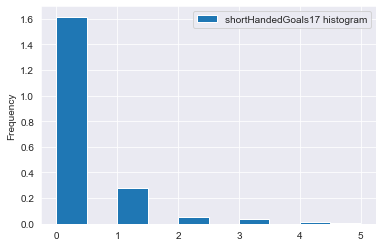

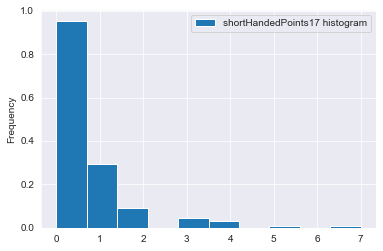

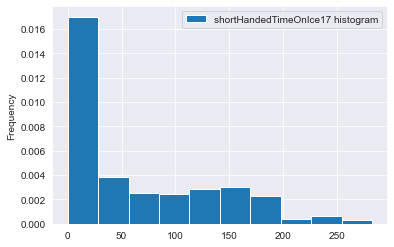

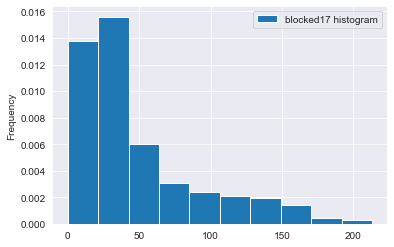

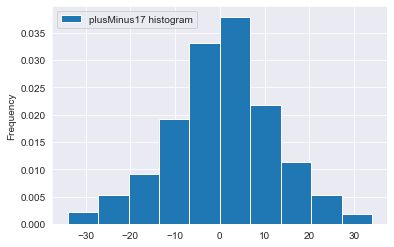

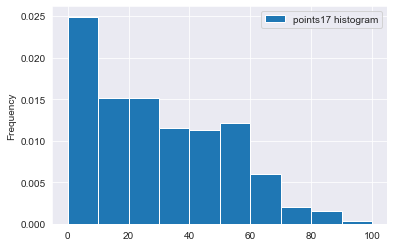

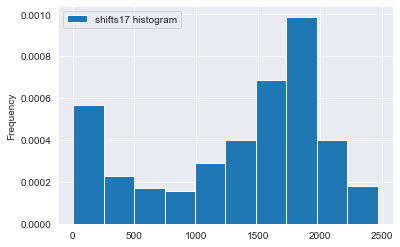

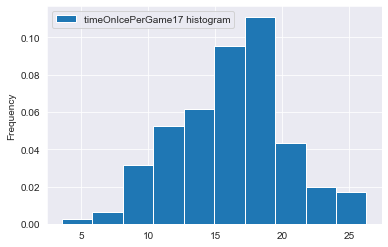

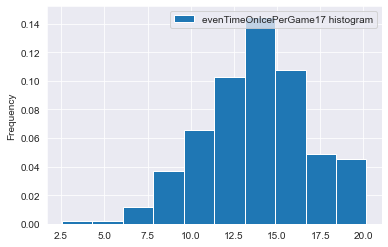

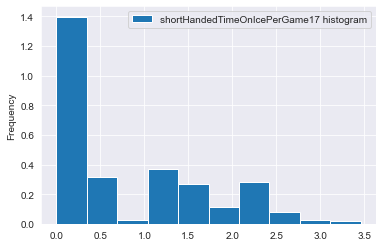

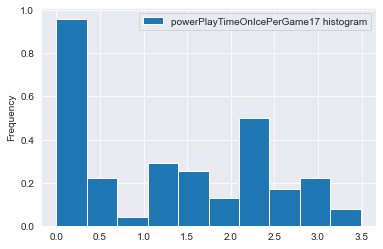

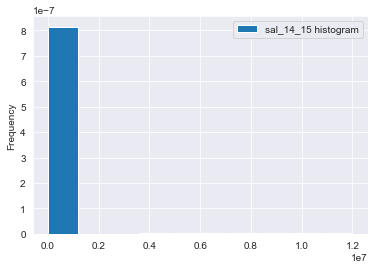

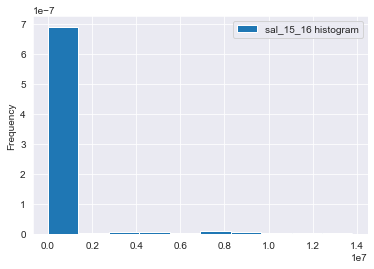

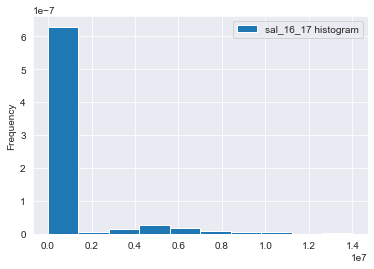

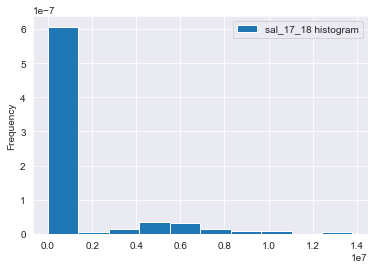

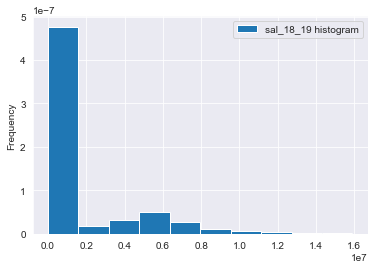

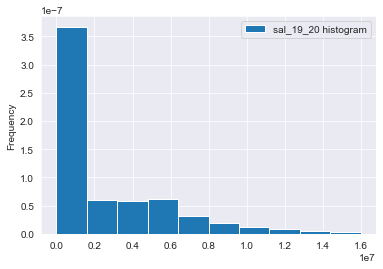

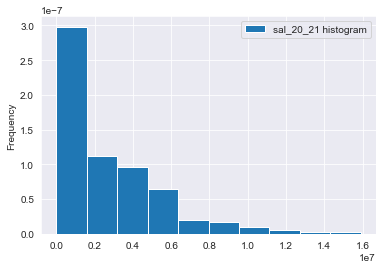

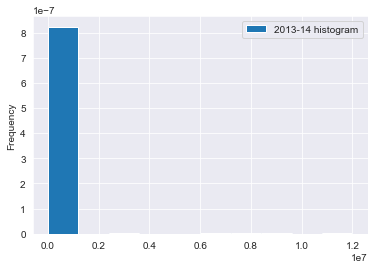

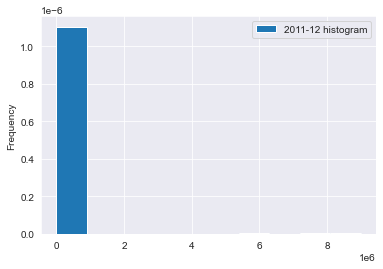

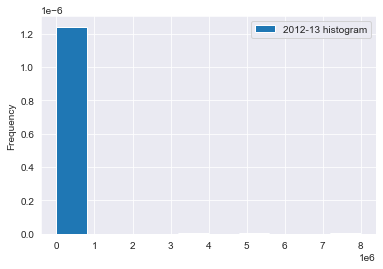

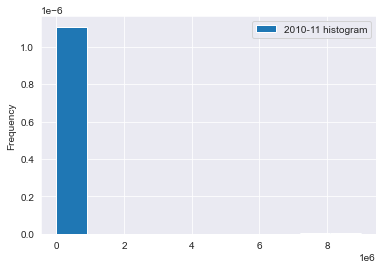

In [7]:
for column in df_no_cats.columns:
    df_no_cats[column].plot.hist(density=True, label = column+' histogram')
    plt.legend()
    plt.show()

#### Reviewing the above charts we can see that our data is not normally distributed and we will need to incorporatre some form a scaling. Another method to indicate this issue is by calling the describe function on our dataframe. Below we can see that our values are drastically different within a column and accross the dataframe. Moving forward we will use a standardscaler in our pipeline. 

In [8]:
df_no_cats.describe()

,birthDate,currentAge,height,weight,timeOnIce20,assists20,goals20,pim20,shots20,games20,hits20,powerPlayGoals20,powerPlayPoints20,powerPlayTimeOnIce20,evenTimeOnIce20,penaltyMinutes20,faceOffPct20,shotPct20,gameWinningGoals20,overTimeGoals20,shortHandedGoals20,shortHandedPoints20,shortHandedTimeOnIce20,blocked20,plusMinus20,points20,shifts20,timeOnIcePerGame20,evenTimeOnIcePerGame20,shortHandedTimeOnIcePerGame20,powerPlayTimeOnIcePerGame20,timeOnIce19,assists19,goals19,pim19,shots19,games19,hits19,powerPlayGoals19,powerPlayPoints19,powerPlayTimeOnIce19,evenTimeOnIce19,penaltyMinutes19,faceOffPct19,shotPct19,gameWinningGoals19,overTimeGoals19,shortHandedGoals19,shortHandedPoints19,shortHandedTimeOnIce19,blocked19,plusMinus19,points19,shifts19,timeOnIcePerGame19,evenTimeOnIcePerGame19,shortHandedTimeOnIcePerGame19,powerPlayTimeOnIcePerGame19,timeOnIce18,assists18,goals18,pim18,shots18,games18,hits18,powerPlayGoals18,powerPlayPoints18,powerPlayTimeOnIce18,evenTimeOnIce18,penaltyMinutes18,faceOffPct18,shotPct18,gameWinningGoals18,overTimeGoals18,shortHandedGoals18,shortHandedPoints18,shortHandedTimeOnIce18,blocked18,plusMinus18,points18,shifts18,timeOnIcePerGame18,evenTimeOnIcePerGame18,shortHandedTimeOnIcePerGame18,powerPlayTimeOnIcePerGame18,timeOnIce17,assists17,goals17,pim17,shots17,games17,hits17,powerPlayGoals17,powerPlayPoints17,powerPlayTimeOnIce17,evenTimeOnIce17,penaltyMinutes17,faceOffPct17,shotPct17,gameWinningGoals17,overTimeGoals17,shortHandedGoals17,shortHandedPoints17,shortHandedTimeOnIce17,blocked17,plusMinus17,points17,shifts17,timeOnIcePerGame17,evenTimeOnIcePerGame17,shortHandedTimeOnIcePerGame17,powerPlayTimeOnIcePerGame17,sal_14_15,sal_15_16,sal_16_17,sal_17_18,sal_18_19,sal_19_20,sal_20_21,2013-14,2011-12,2012-13,2010-11
count,487.00,487.00,487.00,487.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,436.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,419.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,384.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,337.00,487.00,487.00,487.00,487.00,487.00,487.00,487.00,487.00,487.00,487.00,487.00
mean,1992.97,27.68,73.08,198.90,953.40,17.01,10.32,25.53,105.41,56.13,66.88,2.13,6.16,85.21,807.57,25.53,28.70,8.94,1.55,0.24,0.30,0.59,60.27,42.42,0.22,27.33,1201.93,16.30,13.90,0.89,1.23,1102.66,20.01,12.04,28.75,120.96,64.47,78.15,2.31,6.88,99.38,934.02,28.75,29.94,9.11,1.91,0.35,0.38,0.74,68.87,51.15,0.67,32.05,1397.11,16.32,13.93,0.84,1.25,1089.94,20.08,12.12,28.14,123.56,63.06,71.02,2.79,7.95,104.95,915.63,28.14,30.35,9.15,1.93,0.32,0.33,0.63,69.00,51.40,0.64,32.20,1396.08,16.31,13.85,0.86,1.33,1038.21,18.30,10.93,27.64,113.13,59.37,67.46,2.37,7.15,102.28,872.27,27.64,28.90,8.32,1.85,0.36,0.28,0.58,63.31,47.36,0.29,29.23,1344.25,16.18,13.78,0.79,1.30,179876.80,322818.28,719342.92,1017555.67,1462161.45,2395959.95,2758682.47,92710.47,47227.93,34757.35,34907.60
std,3.94,3.91,2.14,14.36,385.64,12.48,8.67,18.88,58.50,16.78,46.82,3.00,7.46,81.09,309.76,18.88,23.98,5.17,1.74,0.55,0.71,1.07,61.94,32.13,10.88,19.37,441.56,3.78,2.86,0.92,1.17,484.40,15.12,10.42,21.68,68.84,21.70,55.84,3.42,8.52,93.79,389.83,21.68,25.31,6.92,1.94,0.73,0.81,1.30,70.82,40.75,11.88,23.62,566.59,3.94,2.97,0.87,1.16,507.87,15.19,10.20,20.02,73.16,23.40,51.59,3.61,9.20,94.59,407.36,20.02,24.01,7.27,2.17,0.73,0.72,1.05,71.16,42.86,12.54,23.54,611.35,3.99,2.92,0.89,1.16,562.55,14.29,9.70,21.96,74.09,26.93,53.17,3.09,8.06,91.91,455.14,21.96,24.53,5.42,2.12,0.72,0.70,1.09,

#### Next lets get create a Linear Regression model with only our numerical features. 

# Modeling

#### Train Test Split No Categoricals

In [9]:
# df_no_cats = df.drop(df_cat_cols, axis=1)

X = df_no_cats.drop('sal_20_21', axis=1)
y = df_no_cats['sal_20_21']

X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(X,y, random_state=42)

#### Baseline Linear Regression Model

In [10]:
numeric_features = X_train_num.columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LinearRegression())])

clf.fit(X_train_num, y_train_num)
print("model train score: %.3f" % clf.score(X_train_num, y_train_num))
print("model test score: %.3f" % clf.score(X_test_num, y_test_num))


train_yhat = clf.predict(X_train_num)
test_yhat = clf.predict(X_test_num)

train_rmse = np.sqrt(mean_squared_error(y_train_num, train_yhat))
test_rmse = np.sqrt(mean_squared_error(y_test_num, test_yhat))

print(f'train rmse: {train_rmse}')
print(f'test rmse: {test_rmse}')

model train score: 0.876
model test score: -5585316840090409407348736.000
train rmse: 949620.5500596225
test rmse: 6.053958282784772e+18


#### With a score of -infinity there is defnitely room for improvement. Lets take a look at our correlations and filter out any highly correlated columns.

#### After running the below cells (89 & 90), I found it best to drop the below columns as they're less applicable to our model than 'sal_18_19' or sal_19_20'. 

In [11]:
X_train_num.drop(['2010-11', '2012-13', '2011-12', '2013-14', 'sal_14_15', 'sal_15_16', 'sal_16_17',\
                 'sal_17_18'], axis=1, inplace=True)

X_test_num.drop(['2010-11', '2012-13', '2011-12', '2013-14', 'sal_14_15', 'sal_15_16', 'sal_16_17',\
                 'sal_17_18'], axis=1, inplace=True)

#### Below we will filter our dataframes based on columns that have colinearity value of less than .7.

In [12]:
correlated_features = set()
correlation_matrix = X_train_num.corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.70:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
            
X_train_num.drop(labels=correlated_features, axis=1, inplace=True)
X_test_num.drop(labels=correlated_features, axis=1, inplace=True)

In [13]:
df_corr=X_train_num.corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))
df_corr.set_index(['pairs'], inplace = True)
df_corr.drop(columns=['level_1', 'level_0'], inplace = True)
df_corr.columns = ['cc']
df_corr.drop_duplicates(inplace=True)
df_corr = df_corr[df_corr['cc'] < 1.0000]
df_corr.head()

,cc
pairs,
"(faceOffPct19, faceOffPct20)",0.69
"(faceOffPct17, faceOffPct20)",0.69
"(timeOnIce19, timeOnIce20)",0.67
"(sal_19_20, sal_18_19)",0.67
"(hits18, hits17)",0.66


#### Below we take a look at our updated features. As seen above goals and time on ice had a strong positive correlation with salary. Also, I assume that age/birthDate may have an effect on our model building. We wil continue with our linear regression model to see if we can get an increase in model performace. 

In [14]:
X_train_num.columns.tolist()

['birthDate',
 'height',
 'timeOnIce20',
 'goals20',
 'pim20',
 'hits20',
 'faceOffPct20',
 'shotPct20',
 'overTimeGoals20',
 'shortHandedGoals20',
 'shortHandedTimeOnIce20',
 'blocked20',
 'plusMinus20',
 'timeOnIce19',
 'pim19',
 'faceOffPct19',
 'shotPct19',
 'overTimeGoals19',
 'shortHandedGoals19',
 'plusMinus19',
 'pim18',
 'hits18',
 'shotPct18',
 'shortHandedGoals18',
 'plusMinus18',
 'pim17',
 'hits17',
 'faceOffPct17',
 'shotPct17',
 'overTimeGoals17',
 'shortHandedGoals17',
 'plusMinus17',
 'sal_18_19',
 'sal_19_20']

In [15]:
numeric_features = X_train_num.columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LinearRegression())])

clf.fit(X_train_num, y_train_num)

print("model train score: %.3f" % clf.score(X_train_num, y_train_num))
print("model test score: %.3f" % clf.score(X_test_num, y_test_num))

train_yhat = clf.predict(X_train_num)
test_yhat = clf.predict(X_test_num)

train_rmse = np.sqrt(mean_squared_error(y_train_num, train_yhat))
test_rmse = np.sqrt(mean_squared_error(y_test_num, test_yhat))

print(f'train rmse: {train_rmse}')
print(f'test rmse: {test_rmse}')

model train score: 0.776
model test score: 0.625
train rmse: 1276683.5013176738
test rmse: 1568798.7752676385


#### Our test score jumped by an incredible amount. Next we will add in our categorical columns to see if that makes a difference. 

#### We will start by creating a new dataframe with our selected features and categorical features and joining it with the categorical features selected from before.

In [16]:
df_w_cats = pd.concat([X, df[df_cat_cols]], axis=1)
df_w_cats = pd.concat([df_w_cats, y], axis=1)

### Train Test Split With Categoricals

In [17]:
X_cat = df_w_cats.drop('sal_20_21', axis=1)
y_cat = df_w_cats['sal_20_21']

X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y_cat, random_state=42)

#### We start adding categoricals by getting every possible combination of columns. 

In [18]:
total_combos = []
data = df_cat_cols
for col in range(0, len(data)+1):
    for subset in combinations(data, col):
        total_combos.append(subset)

#### Next we iterate over our pipeline with our column cobination storing our RMSE and R2 values in separate dictionaries. We will use these values to see if any combination brings an increase to our models performance. 

In [19]:
cat_scores_rmse = {}
cat_scores_r2 = {}

for i in range(len(total_combos)):
    
    for num, val in enumerate(total_combos):
        
        if num == i:
            
            cat = df[list(val)]
                
            numeric_features = X_train_cat.select_dtypes(['int', 'float']).columns.tolist()

            numeric_transformer = Pipeline(steps=[
                                            ('imputer', SimpleImputer(strategy='median')),
                                            ('scaler', StandardScaler())])

            categorical_features = cat.columns.tolist()

            categorical_transformer = OneHotEncoder(handle_unknown='ignore')

            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', numeric_transformer, numeric_features),
                    ('cat', categorical_transformer, categorical_features)])

            clf = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('classifier', LinearRegression())])

            clf.fit(X_train_cat, y_train_cat)

            yhat = clf.predict(X_test_cat)

            cat_scores_rmse[i] = np.sqrt(mean_squared_error(y_test_cat, yhat))
            cat_scores_r2[i] = clf.score(X_test_cat, y_test_cat)

In [20]:
minval_rmse = min(cat_scores_rmse.values())
minval_rmse

1955672.5686956886

In [21]:
maxval_r2 = max(cat_scores_r2.values())
maxval_r2

0.417144022265888

#### As we can see above we have no improvement with any combination of categoricals. We will move forward with only using our numerical dataframe.

# Lazy Regressor

#### Below we will run a lazy predict which runs a variety of vanilla models to get baseline R2 and RMSE scores. We'll use this information to gain insight for our model building process. Once ran, we will select the top three models to see if we can get any improvement from out Linear Regression Model.

In [22]:
lazy_reg = LazyRegressor(predictions=True, random_state=42)

models, predictions = lazy_reg.fit(X_train_num, X_test_num, y_train_num, y_test_num)

models

100%|██████████| 41/41 [00:03<00:00, 13.56it/s]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,0.65,0.75,1284154.39,0.26
XGBRegressor,0.65,0.75,1289074.45,0.23
RandomForestRegressor,0.63,0.74,1315785.42,0.36
GradientBoostingRegressor,0.61,0.72,1356770.38,0.17
BaggingRegressor,0.60,0.71,1373184.96,0.04
HistGradientBoostingRegressor,0.57,0.69,1420824.18,0.66
OrthogonalMatchingPursuit,0.57,0.69,1429417.20,0.01
LGBMRegressor,0.56,0.68,1439756.06,0.05
OrthogonalMatchingPursuitCV,0.54,0.67,1473868.01,0.01


#### Below we will pass our top three models through a grid search and try to tune our models to achieve the highest R-squared score. I chose to use the 'neg_root_mean_squared_error' socring parameter in the GridSearchCV. Since I am predicting player salaries I found it best to use a scoring parameter that will return the lowest dollar amount error.

#### For all three models our process is identical:

* Baseline or vanilla model 
* GridSearch hyper parameter tuning
* Pickle model to models folder
* Results

# ExtraTreesRegressor

#### Baseline Model:

In [23]:
numeric_features = X_train_num.columns.tolist()


numeric_transformer = Pipeline(steps=[
                                ('imputer', SimpleImputer(strategy='median')),
                                ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', ExtraTreesRegressor())])

clf.fit(X_train_num, y_train_num)

y_hat = clf.predict(X_test_num)

print('R2 test:', r2_score(y_test_num, y_hat))

R2 test: 0.744766110774708


#### 

#### Hyperparameter tuning:

In [24]:
# numeric_features = X_train_num.columns.tolist()


# numeric_transformer = Pipeline(steps=[
#                                 ('imputer', SimpleImputer(strategy='median')),
#                                 ('scaler', StandardScaler())])

# preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])

# clf = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', ExtraTreesRegressor())])
# param_grid = {
#     'classifier__n_estimators': range(30,200,15),
#     'classifier__max_depth': [None, 5, 10, 20, 35, 50],
#     'classifier__min_samples_split': [2,3,4,5],
#     'classifier__min_samples_leaf': range(1,10),
#     'classifier__max_features': ['auto', 'sqrt', 'log2'],
#     'classifier__bootstrap': [True, False],
#     'classifier__oob_score': [True, False],
#     'classifier__ccp_alpha': [0, 1,2]
# }

# grid_search_etr = GridSearchCV(clf, param_grid, n_jobs=-1, scoring='neg_root_mean_squared_error')

# grid_search_etr.fit(X_train_num, y_train_num)

#### Pickling:

In [25]:
# pickle_out = open("models/extratreesregressor","wb")
# pickle.dump(grid_search_etr, pickle_out)
# pickle_out.close()

In [26]:
pickle_in = open("models/extratreesregressor","rb")
etr = pickle.load(pickle_in)

#### Models Best Parameters:

In [27]:
etr.best_params_

{'classifier__bootstrap': False,
 'classifier__ccp_alpha': 1,
 'classifier__max_depth': 10,
 'classifier__max_features': 'auto',
 'classifier__min_samples_leaf': 2,
 'classifier__min_samples_split': 3,
 'classifier__n_estimators': 60,
 'classifier__oob_score': False}

#### RMSE:

In [28]:
test_yhat = etr.predict(X_test_num)
train_yhat = etr.predict(X_train_num)

print(f'RMSE Test ExtraTreeRegressor: {np.sqrt(mean_squared_error(y_test_num, test_yhat))}')
print(f'RMSE Train ExtraTreeRegressor: {np.sqrt(mean_squared_error(y_train_num, train_yhat))}')

RMSE Test ExtraTreeRegressor: 1287182.260670608
RMSE Train ExtraTreeRegressor: 379814.22509152


#### R2 Score:

In [29]:
etr_r2_train = r2_score(y_train_num, train_yhat)
etr_r2_test = r2_score(y_test_num, test_yhat)

print('etr r2 Train:', etr_r2_train)
print('etr r2 Test:', etr_r2_test)

etr r2 Train: 0.9802148748539048
etr r2 Test: 0.7475071651376457


#### Model Summary: 

#### The baseline model had a score of .73 and we ended with a score of .75 which is a small increase in the right direction. Looking at our RMSE and R2 score we can see that our model is overfit as our training and testing scores are drastically different in their respective directions. 

# RandomForestRegressor

#### Baseline Model:

In [30]:
numeric_features = X_train_num.columns.tolist()


numeric_transformer = Pipeline(steps=[
                                ('imputer', SimpleImputer(strategy='median')),
                                ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestRegressor())])

clf.fit(X_train_num, y_train_num)

y_hat = clf.predict(X_test_num)

print('R2 test:', r2_score(y_test_num, y_hat))

R2 test: 0.7312654873392432


####

#### Hyperparameter Tuning:

In [31]:
# numeric_features = X_train_num.columns.tolist()


# numeric_transformer = Pipeline(steps=[
#                                 ('imputer', SimpleImputer(strategy='median')),
#                                 ('scaler', StandardScaler())])

# preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])

# clf = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', RandomForestRegressor())])
# param_grid = {
#     'classifier__n_estimators': range(100,200,25),
#     'classifier__max_depth': [None, 10, 20, 35, 50],
#     'classifier__min_samples_split': [2,3,4,5],
#     'classifier__min_samples_leaf': range(1,10, 2),
#     'classifier__max_features': ['auto', 'sqrt', 'log2'],
#     'classifier__bootstrap': [True, False],
#     'classifier__oob_score': [True, False],
#     'classifier__ccp_alpha': [0, 1,2]  
# }

# grid_search_rf = GridSearchCV(clf, param_grid, n_jobs=-1, scoring='neg_root_mean_squared_error')

# grid_search_rf.fit(X_train_num, y_train_num)

#### Pickling:

In [32]:
# pickle_out = open("models/randomforestregressor","wb")
# pickle.dump(grid_search_rf, pickle_out)
# pickle_out.close()

In [33]:
pickle_in = open("models/randomforestregressor","rb")
rf = pickle.load(pickle_in)

#### Models Best Parameters:

In [34]:
rf.best_params_

{'classifier__bootstrap': True,
 'classifier__ccp_alpha': 0,
 'classifier__max_depth': 10,
 'classifier__max_features': 'auto',
 'classifier__min_samples_leaf': 3,
 'classifier__min_samples_split': 5,
 'classifier__n_estimators': 100,
 'classifier__oob_score': True}

#### RMSE:

In [35]:
test_yhat = rf.predict(X_test_num)
train_yhat = rf.predict(X_train_num)

print(f'RMSE Test RandomForestRegressor: {np.sqrt(mean_squared_error(y_test_num, test_yhat))}')
print(f'RMSE Train RandomForestRegressor: {np.sqrt(mean_squared_error(y_train_num, train_yhat))}')

RMSE Test RandomForestRegressor: 1270232.6322158116
RMSE Train RandomForestRegressor: 667017.4508861409


#### R2 Score:

In [36]:
rf_r2_train = r2_score(y_train_num, train_yhat)
rf_r2_test = r2_score(y_test_num, test_yhat)

print('RF R2 Train:', rf_r2_train)
print('RF R2 Test:', rf_r2_test)

RF R2 Train: 0.9389802053447218
RF R2 Test: 0.754113039951041


#### Model Summary:

#### Random Forest performed better than extra trees with a higher R2 score and a lower RMSE across both the training and testing sets. You can still see the model overfitting with the scoring differences...greedy models...

# XGBRegressor

#### Baseline Model:

In [37]:
numeric_features = X_train_num.columns.tolist()


numeric_transformer = Pipeline(steps=[
                                ('imputer', SimpleImputer(strategy='median')),
                                ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBRegressor())])

clf.fit(X_train_num, y_train_num)

y_hat = clf.predict(X_test_num)

print('R2 test:', r2_score(y_test_num, y_hat))

R2 test: 0.7389091071627298


#### Hyperparameter Tuning:

In [38]:
# numeric_features = X_train_num.columns.tolist()


# numeric_transformer = Pipeline(steps=[
#                                 ('imputer', SimpleImputer(strategy='median')),
#                                 ('scaler', StandardScaler())])

# preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])

# clf = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', XGBRegressor())])
# param_grid = {
#     'classifier__n_estimators': range(50,200,10),
#     'classifier__max_depth': [None, 5, 10, 20, 35, 50],
#     'classifier__learning_rate': [.0001, .001, .01, .1, 1, 2],
#     'classifier__booster': ['gblinear', 'dart', 'gbtree']
# }

# grid_search_xgb = GridSearchCV(clf, param_grid, n_jobs=-1, scoring='neg_root_mean_squared_error')

# grid_search_xgb.fit(X_train_num, y_train_num)

#### Pickling:

In [39]:
# pickle_out = open("models/xgbregressor","wb")
# pickle.dump(grid_search_xgb, pickle_out)
# pickle_out.close()

In [40]:
pickle_in = open("models/xgbregressor","rb")
xgb = pickle.load(pickle_in)

#### Models Best Parameters:

In [41]:
xgb.best_params_

{'classifier__booster': 'gbtree',
 'classifier__learning_rate': 0.1,
 'classifier__max_depth': 10,
 'classifier__n_estimators': 50}

#### RMSE:

In [42]:
test_yhat = xgb.predict(X_test_num)
train_yhat = xgb.predict(X_train_num)

print(f'RMSE Test XGBRegressor: {np.sqrt(mean_squared_error(y_test_num, test_yhat))}')
print(f'RMSE Train XGBRegressor: {np.sqrt(mean_squared_error(y_train_num, train_yhat))}')

RMSE Test XGBRegressor: 1333394.1188253902
RMSE Train XGBRegressor: 117448.00354423512


#### R2 Score:

In [43]:
xgb_r2_train = r2_score(y_train_num, train_yhat)
xgb_r2_test = r2_score(y_test_num, test_yhat)

print('XGB R2 Train:', xgb_r2_train)
print('XGB R2 Test:', xgb_r2_test)

XGB R2 Train: 0.9981081459602092
XGB R2 Test: 0.7290519454028246


#### Model Summary:

#### For our final model we see a trend of overfitting developing. XGB Regressor performed the worst out of our three models as we can see our lowest R2 score and highest RMSE. 

# Evaluation

## Final Model Random Forest Regressor

#### All of our models are very comparable to one another but Random Forest took the Stanley Cup. 

#### Below we will import our saved model to verify are applying accurate variables, identify the feature importances for our model, and evaluate our model. 

In [44]:
pickle_in = open("models/randomforestregressor","rb")

rf = pickle.load(pickle_in)

#### To start, we will dive into our pipeline and pull out our feature importance values. Next I created a dictionary to store descriptions with their associated values, sorted the dictionary by value, and plotted.

In [45]:
feat_import = rf.best_estimator_.named_steps['classifier'].feature_importances_

feature_importances = dict(zip(X_train_num, feat_import))

feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)}

feature_importances

{'sal_19_20': 0.6780274476873939,
 'timeOnIce19': 0.09880700212279121,
 'timeOnIce20': 0.0516060576319846,
 'goals20': 0.03984383785777042,
 'hits18': 0.014059765430248356,
 'sal_18_19': 0.012756491635374439,
 'shortHandedTimeOnIce20': 0.009778339225457693,
 'shotPct17': 0.008041881828608854,
 'plusMinus19': 0.006927788831920408,
 'hits20': 0.006869535944841399,
 'shotPct20': 0.006544885277834824,
 'plusMinus20': 0.0060274684336196135,
 'shotPct19': 0.005523886545066997,
 'blocked20': 0.005142806471510504,
 'birthDate': 0.0049756272102861295,
 'hits17': 0.004866585383690297,
 'plusMinus17': 0.004460903346877345,
 'plusMinus18': 0.004244020644649516,
 'pim19': 0.003960456091139014,
 'faceOffPct17': 0.003638392825097414,
 'pim20': 0.0032969996223486653,
 'pim18': 0.003149485203213992,
 'pim17': 0.002994603101457094,
 'shotPct18': 0.002689393368748589,
 'overTimeGoals19': 0.0023355571832322465,
 'height': 0.0022758344455587063,
 'faceOffPct20': 0.0020307283823706294,
 'faceOffPct19': 0.00

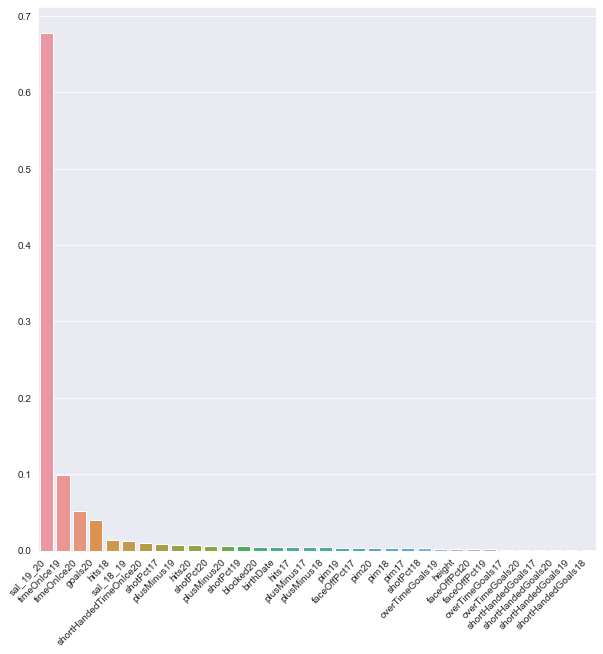

In [46]:
y = [val for val in feature_importances.values()]
x = [key for key in feature_importances.keys()]

fig, ax = plt.subplots(figsize=(10,10))

sns.barplot(x,y)

plt.xticks(rotation=45, ha='right')

plt.savefig('images/feature_importances');

### Feature Importances:

#### We can see that our top 5 features are: 

* sal_19_20
* timeOnIce19
* timeOnIce20
* goals20
* hits18

#### It's interesting how time on ice from two seasons ago carries more weight than time on ice from the past season. Also, hits 18 carries more weight than hits20.

#### Now that we have our feature importances, lets visually compare our models predicted values vs the true values.

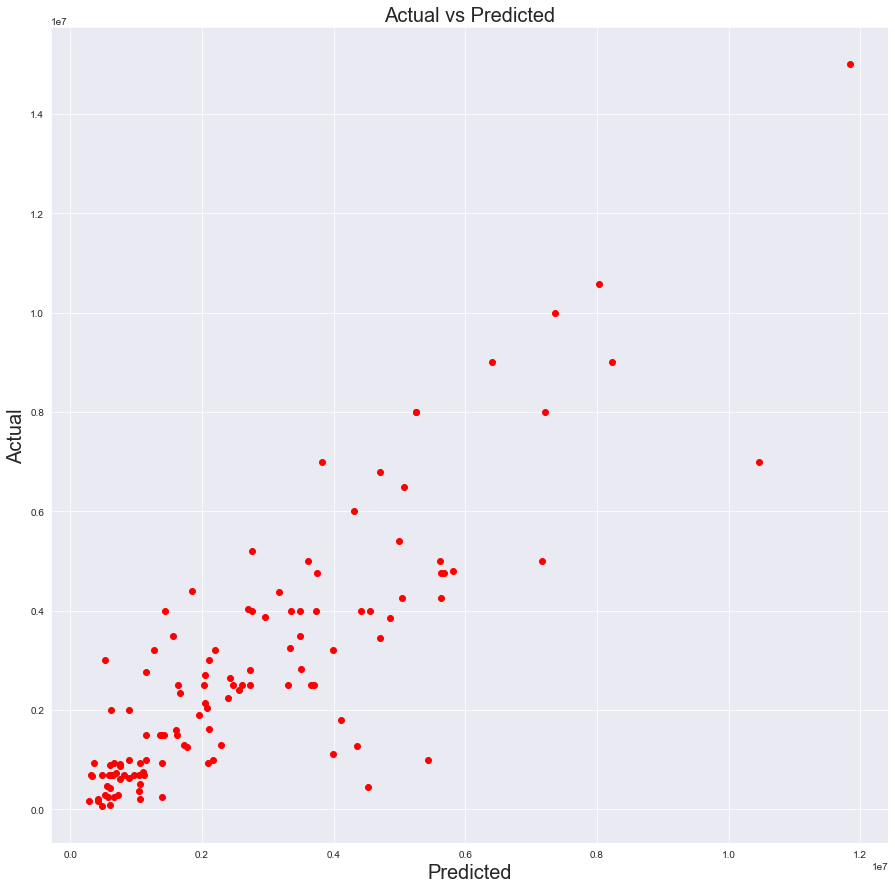

In [47]:
fig, ax = plt.subplots(figsize=(15,15))

ax.scatter(test_yhat, y_test_num , color='red', label='Predicted')

plt.title('Actual vs Predicted', fontsize=20)

plt.xlabel('Predicted', fontsize=20)

plt.ylabel('Actual', fontsize=20)

plt.savefig('images/final_model');

#### Above we have a generic plot showing our predicted values vs our actual values. It doesn't give us a good representation of where our errors are though. 

#### Below we will create a new dataframe and filter based on a 1.2M dollar threshold and replot to see our errors. 

In [48]:
analysis = pd.DataFrame(test_yhat - y_test_num)

analysis['actual'] = y_test_num

analysis['predicted'] = test_yhat

analysis_low = analysis[(analysis['sal_20_21'] <= 1200000) & (analysis['sal_20_21'] >= -1200000)]

analysis_pos = analysis[(analysis['sal_20_21'] >= 1200000)]

analysis_neg = analysis[(analysis['sal_20_21'] <= -1200000)]

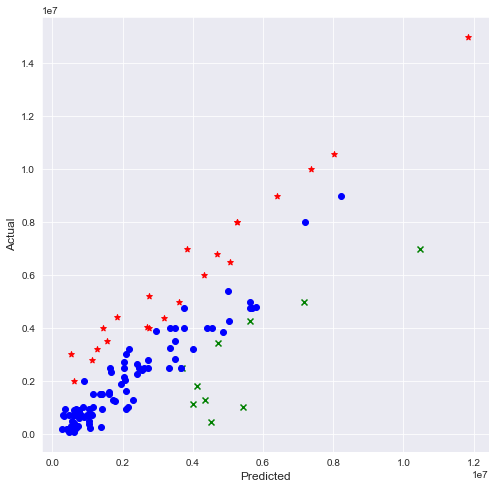

In [49]:
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(analysis_pos['predicted'], analysis_pos['actual'], marker='x', color = 'green', label='> $1.2M')

ax.scatter(analysis_neg['predicted'], analysis_neg['actual'], marker='*', color = 'red', label='< -$1.2M')

ax.scatter(analysis_low['predicted'], analysis_low['actual'], marker='o', color='blue', label='< +/- $1.2M')

plt.xlabel('Predicted', fontsize=12)

plt.ylabel('Actual', fontsize=12)

plt.savefig('images/final_model');

#### That's easier on the eyes, it looks like we have a few outliers in the dataframe but it also looks like we have clusters of values that we're missing on. This will need further analysis. 

#### Below I ran a quick count to get a percentage of our errors. We can see that 22% of our predictions are outside of threshold window. Not bad! 

In [50]:
len(analysis_neg) + len(analysis_pos) / len(analysis)

22.081967213114755

### Further Analysis

#### Below, I ran a describe on all of our dataframes and isolated the mean for each column. I then subtracted the original dataframes mean from the isolated errors above (green and red indicators) separately. We will visually review major differences between the dataframes to see if we can identify weak points within our model. 

#### To start, we will create new dataframes:

In [51]:
final_analysis_pos = analysis[(analysis['sal_20_21'] >= 1200000)]

final_analysis_neg = analysis[(analysis['sal_20_21'] <= -1200000)]


final_analysis_pos = final_analysis_pos.reset_index()

final_analysis_neg = final_analysis_neg.reset_index()

#### Now, select the mean row from our original dataframe

In [52]:
df = df.reset_index()

df_describe = df.describe().reset_index().loc[1:1, :]

#### I had to rethink the code below 24 hours after writing it so, below is a breakdown of whats happening:

* Line 1: filter our original df by common index values in final_analysis_pos
* Line 2: filter new dataframes by x* 
    * Note: x was denoted as columns within our datagframe (see cell 123)
* Line 3: call the describe function and isolate the mean values for all columns
* Line 4: drop index calumn as it is unneeded
* Line 5: subtract original mean values from entire dataframe from our final_analysis_pos means

#### The output shows the difference in valus between the original and our positive analysis mean's. 

In [53]:
final_analysis_df_pos = df[df['index'].isin(final_analysis_pos['index'])]

final_analysis_df_pos = final_analysis_df_pos[x]

pos = final_analysis_df_pos.describe().reset_index().loc[1:1, :]

pos = pos.drop('index', axis=1)

pos = pos.subtract(df_describe[x])

pos

,sal_19_20,timeOnIce19,timeOnIce20,goals20,hits18,sal_18_19,shortHandedTimeOnIce20,shotPct17,plusMinus19,hits20,shotPct20,plusMinus20,shotPct19,blocked20,birthDate,hits17,plusMinus17,plusMinus18,pim19,faceOffPct17,pim20,pim18,pim17,shotPct18,overTimeGoals19,height,faceOffPct20,faceOffPct19,overTimeGoals17,overTimeGoals20,shortHandedGoals17,shortHandedGoals20,shortHandedGoals19,shortHandedGoals18
1,1696457.35,285.56,209.16,8.08,12.18,2714626.55,10.66,2.69,-3.17,26.12,2.75,1.98,2.33,-8.02,-4.47,13.64,2.71,6.96,15.15,7.72,17.27,6.16,17.46,3.80,0.25,-0.18,11.67,13.07,0.34,0.06,0.22,0.20,0.72,0.67


#### Below we repeat the above steps but for values we over under predicted on.

In [54]:
final_analysis_df_neg = df[df['index'].isin(final_analysis_neg['index'])]

final_analysis_df_neg = final_analysis_df_neg[x]

neg = final_analysis_df_neg.describe().reset_index().loc[1:1, :]

neg = neg.drop('index', axis=1)

neg = neg.subtract(df_describe[x])

neg

,sal_19_20,timeOnIce19,timeOnIce20,goals20,hits18,sal_18_19,shortHandedTimeOnIce20,shotPct17,plusMinus19,hits20,shotPct20,plusMinus20,shotPct19,blocked20,birthDate,hits17,plusMinus17,plusMinus18,pim19,faceOffPct17,pim20,pim18,pim17,shotPct18,overTimeGoals19,height,faceOffPct20,faceOffPct19,overTimeGoals17,overTimeGoals20,shortHandedGoals17,shortHandedGoals20,shortHandedGoals19,shortHandedGoals18
1,1602860.96,235.20,247.21,3.30,-5.38,43520.37,0.72,-0.62,5.19,1.17,0.45,3.44,-0.11,14.68,0.40,-0.56,3.86,1.59,-1.08,-5.38,2.75,-3.78,2.26,-0.01,-0.21,-0.12,-12.13,13.00,-0.04,0.23,-0.23,0.13,0.19,-0.01


#### Next, lets filter these dataframes by the top 10 important features. 

In [55]:
top_10_feats = ['hits20', 'plusMinus19', 'shotPct17', 'shortHandedTimeOnIce20', 'sal_18_19', 'hits18', 'goals20', 'timeOnIce20', 'timeOnIce19', 'sal_19_20']

In [56]:
pos[top_10_feats]

,hits20,plusMinus19,shotPct17,shortHandedTimeOnIce20,sal_18_19,hits18,goals20,timeOnIce20,timeOnIce19,sal_19_20
1,26.12,-3.17,2.69,10.66,2714626.55,12.18,8.08,209.16,285.56,1696457.35


In [57]:
neg[top_10_feats]

,hits20,plusMinus19,shotPct17,shortHandedTimeOnIce20,sal_18_19,hits18,goals20,timeOnIce20,timeOnIce19,sal_19_20
1,1.17,5.19,-0.62,0.72,43520.37,-5.38,3.30,247.21,235.20,1602860.96


#### Finally lets repeat the above steps but see the differences between the pos and neg dataframes. 

In [58]:
pos_vs_neg = final_analysis_df_pos.describe().reset_index().loc[1:1,:].drop('index', axis=1) - final_analysis_df_neg.describe().reset_index().loc[1:1,:].drop('index', axis=1)

pos_vs_neg[top_10_feats]

,hits20,plusMinus19,shotPct17,shortHandedTimeOnIce20,sal_18_19,hits18,goals20,timeOnIce20,timeOnIce19,sal_19_20
1,24.95,-8.36,3.31,9.94,2671106.18,17.56,4.78,-38.05,50.36,93596.39


#### Evaluating the final model, we can see that we're over predicting on players that have a higher salary for the 2018-2019 season and under predicting on players that have, generally better stats within our top ten features. Lets dive into these dataframes to see if any other features stand out. 

In [59]:
df[df['index'].isin(final_analysis_pos['index'])]

,index,type,birthDate,currentAge,birthCity,birthStateProvince,birthCountry,nationality,height,weight,active,alternateCaptain,captain,rookie,shootsCatches,rosterStatus,timeOnIce20,assists20,goals20,pim20,shots20,games20,hits20,powerPlayGoals20,powerPlayPoints20,powerPlayTimeOnIce20,evenTimeOnIce20,penaltyMinutes20,faceOffPct20,shotPct20,gameWinningGoals20,overTimeGoals20,shortHandedGoals20,shortHandedPoints20,shortHandedTimeOnIce20,blocked20,plusMinus20,points20,shifts20,timeOnIcePerGame20,evenTimeOnIcePerGame20,shortHandedTimeOnIcePerGame20,powerPlayTimeOnIcePerGame20,timeOnIce19,assists19,goals19,pim19,shots19,games19,hits19,powerPlayGoals19,powerPlayPoints19,powerPlayTimeOnIce19,evenTimeOnIce19,penaltyMinutes19,faceOffPct19,shotPct19,gameWinningGoals19,overTimeGoals19,shortHandedGoals19,shortHandedPoints19,shortHandedTimeOnIce19,blocked19,plusMinus19,points19,shifts19,timeOnIcePerGame19,evenTimeOnIcePerGame19,shortHandedTimeOnIcePerGame19,powerPlayTimeOnIcePerGame19,timeOnIce18,assists18,goals18,pim18,shots18,games18,hits18,powerPlayGoals18,powerPlayPoints18,powerPlayTimeOnIce18,evenTimeOnIce18,penaltyMinutes18,faceOffPct18,shotPct18,gameWinningGoals18,overTimeGoals18,shortHandedGoals18,shortHandedPoints18,shortHandedTimeOnIce18,blocked18,plusMinus18,points18,shifts18,timeOnIcePerGame18,evenTimeOnIcePerGame18,shortHandedTimeOnIcePerGame18,powerPlayTimeOnIcePerGame18,timeOnIce17,assists17,goals17,pim17,shots17,games17,hits17,powerPlayGoals17,powerPlayPoints17,powerPlayTimeOnIce17,evenTimeOnIce17,penaltyMinutes17,faceOffPct17,shotPct17,gameWinningGoals17,overTimeGoals17,shortHandedGoals17,shortHandedPoints17,shortHandedTimeOnIce17,blocked17,plusMinus17,points17,shifts17,timeOnIcePerGame17,evenTimeOnIcePerGame17,shortHandedTimeOnIcePerGame17,powerPlayTimeOnIcePerGame17,sal_14_15,sal_15_16,sal_16_17,sal_17_18,sal_18_19,sal_19_20,sal_20_21,2013-14,2011-12,2012-13,2010-11
63,63,Forward,1985,36,London,ON,CAN,CAN,75,219,True,False,False,False,R,Y,1016.05,10.00,17.00,36.00,182.00,60.00,66.00,3.00,5.00,110.05,823.13,36.00,51.20,9.30,7.00,1.00,0.00,0.00,82.47,23.00,-21.00,27.00,1385.00,16.56,13.43,1.22,1.50,1380.00,20.00,13.00,42.00,174.00,76.00,80.00,5.00,13.00,187.14,1097.28,42.00,51.26,7.47,1.00,0.00,1.00,2.00,95.18,30.00,-20.00,33.00,1827.00,18.09,14.26,1.15,2.27,481.45,9.00,13.00,2.00,85.00,27.00,27.00,6.00,9.00,85.21,360.29,2.00,55.77,15.29,2.00,1.00,1.00,1.00,35.55,11.00,4.00,22.00,630.00,17.50,13.21,1.19,3.09,1478.37,34.00,32.00,41.00,250.00,82.00,86.00,10.00,22.00,237.27,1116.41,41.00,51.94,12.80,9.00,4.00,1.00,1.00,124.29,37.00,2.00,66.00,1920.00,18.01,13.37,1.31,2.53,6750000.00,7000000.00,7000000.00,6500000.00,5000000.00,3000000.00,448266.00,6500000.00,6000000.00,3658537.00,0.00
84,84,Forward,1988,33,Halifax,NS,CAN,CAN,69,181,True,True,False,False,L,Y,1361.39,59.00,28.00,82.00,185.00,70.00,55.00,5.00,28.00,258.24,992.09,82.00,43.13,15.10,5.00,0.00,1.00,3.00,111.06,19.00,25.00,87.00,1568.00,19.27,14.10,1.35,3.41,1550.16,64.00,36.00,96.00,231.00,79.00,46.00,10.00,34.00,249.57,1176.21,96.00,42.85,15.58,9.00,3.00,3.00,7.00,123.58,19.00,15.00,100.00,1821.00,19.37,14.53,1.34,3.09,1340.41,51.00,34.00,63.00,182.00,68.00,37.00,8.00,23.00,209.45,1008.03,63.00,39.68,18.68,8.00,5.00,1.00,4.00,122.53,25.00,25.00,85.00,1650.00,19.42,14.49,1.48,3.05,1554.55,46.00,39.00,81.00,226.00,80.00,51.00,9.00,24.00,215.44,1187.24,81.00,36.11,17.26,8.00,1.00,3.00,5.00,151.47,35.00,18.00,85.00,1942.00,19.26,14.50,1.53,2.41,0.00,0.00,5000000.00,8000000.00,8000000.00,7500000.00,5000000.00,0.00,0.00,0.00,0.00
113,113,Forward,1984,36,Thunder Bay,ON,CAN,CAN,76,195,True,False,False,False,L,Y,1130.53,28.00,19.00,28.00,113.00,66.00,24.00,5.00,14.00,177.57,934.56,28.00,49.55,16.80,5.00,1.00,0.00,0.00,18.00,22.00,-9.00,47.00,1318.00,17.08,14.09,0.16,2.41,1468.09,30.00,22.00,34.00,215.00,81.00,41.00,7.00,15.00,227.55,1219.21,34.00,51.07,10.23,6.00,0.00,0.00,1.00,20.53,28.00,-7.00,52.00,1695.00,18.07,15.03,0.15,2.48,1460.35,34.00,42.00,42.00,241.00,82.00,42.00,11.

In [60]:
df[df['index'].isin(final_analysis_neg['index'])]

,index,type,birthDate,currentAge,birthCity,birthStateProvince,birthCountry,nationality,height,weight,active,alternateCaptain,captain,rookie,shootsCatches,rosterStatus,timeOnIce20,assists20,goals20,pim20,shots20,games20,hits20,powerPlayGoals20,powerPlayPoints20,powerPlayTimeOnIce20,evenTimeOnIce20,penaltyMinutes20,faceOffPct20,shotPct20,gameWinningGoals20,overTimeGoals20,shortHandedGoals20,shortHandedPoints20,shortHandedTimeOnIce20,blocked20,plusMinus20,points20,shifts20,timeOnIcePerGame20,evenTimeOnIcePerGame20,shortHandedTimeOnIcePerGame20,powerPlayTimeOnIcePerGame20,timeOnIce19,assists19,goals19,pim19,shots19,games19,hits19,powerPlayGoals19,powerPlayPoints19,powerPlayTimeOnIce19,evenTimeOnIce19,penaltyMinutes19,faceOffPct19,shotPct19,gameWinningGoals19,overTimeGoals19,shortHandedGoals19,shortHandedPoints19,shortHandedTimeOnIce19,blocked19,plusMinus19,points19,shifts19,timeOnIcePerGame19,evenTimeOnIcePerGame19,shortHandedTimeOnIcePerGame19,powerPlayTimeOnIcePerGame19,timeOnIce18,assists18,goals18,pim18,shots18,games18,hits18,powerPlayGoals18,powerPlayPoints18,powerPlayTimeOnIce18,evenTimeOnIce18,penaltyMinutes18,faceOffPct18,shotPct18,gameWinningGoals18,overTimeGoals18,shortHandedGoals18,shortHandedPoints18,shortHandedTimeOnIce18,blocked18,plusMinus18,points18,shifts18,timeOnIcePerGame18,evenTimeOnIcePerGame18,shortHandedTimeOnIcePerGame18,powerPlayTimeOnIcePerGame18,timeOnIce17,assists17,goals17,pim17,shots17,games17,hits17,powerPlayGoals17,powerPlayPoints17,powerPlayTimeOnIce17,evenTimeOnIce17,penaltyMinutes17,faceOffPct17,shotPct17,gameWinningGoals17,overTimeGoals17,shortHandedGoals17,shortHandedPoints17,shortHandedTimeOnIce17,blocked17,plusMinus17,points17,shifts17,timeOnIcePerGame17,evenTimeOnIcePerGame17,shortHandedTimeOnIcePerGame17,powerPlayTimeOnIcePerGame17,sal_14_15,sal_15_16,sal_16_17,sal_17_18,sal_18_19,sal_19_20,sal_20_21,2013-14,2011-12,2012-13,2010-11
22,22,Forward,1991,30,Toronto,ON,CAN,CAN,71,195,True,False,False,False,L,Y,686.06,4.00,10.00,41.00,67.00,48.00,133.00,0.00,0.00,2.14,571.52,41.00,53.48,14.90,1.00,0.00,3.00,5.00,112.00,39.00,12.00,14.00,987.00,14.17,11.54,2.20,0.02,1023.44,13.00,20.00,36.00,111.00,73.00,129.00,0.00,0.00,4.59,876.40,36.00,49.06,18.02,3.00,0.00,2.00,3.00,142.05,68.00,22.00,33.00,1476.00,14.01,12.00,1.56,0.04,845.46,10.00,7.00,23.00,74.00,64.00,128.00,0.00,0.00,3.57,694.30,23.00,53.08,9.46,0.00,0.00,1.00,1.00,147.19,53.00,-12.00,17.00,1216.00,13.12,10.51,2.18,0.03,820.30,17.00,8.00,30.00,82.00,59.00,144.00,0.00,1.00,8.45,684.52,30.00,49.64,9.76,1.00,0.00,0.00,0.00,126.53,58.00,9.00,25.00,1254.00,13.54,11.36,2.09,0.08,0.00,0.00,2500000.00,3000000.00,3500000.00,3750000.00,4000000.00,0.00,0.00,0.00,0.00
31,31,Defenseman,1996,25,Umea,Unknown,SWE,SWE,70,184,True,False,False,True,L,Y,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,357.24,3.00,1.00,6.00,24.00,22.00,10.00,1.00,1.00,21.24,335.53,6.00,0.00,4.17,0.00,0.00,0.00,0.00,0.07,14.00,-5.00,4.00,434.00,16.14,15.16,0.00,0.58,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.00,0.00,0.00,0.00,0.00,12000000.00,10570000.00,0.00,0.00,0.00,0.00
39,39,Defenseman,1994,27,Rochester,MI,USA,USA,75,209,True,True,False,False,R,Y,1579.30,20.00,7.00,61.00,168.00,70.00,173.00,4.00,8.00,125.01,1279.20,61.00,0.00,4.20,1.00,0.00,0.00,2.00,175.09,128.00,-12.00,27.00,1908.00,22.33,18.16,2.30,1.47,1876.00,42.00,8.00,58.00,162.00,82.00,112.00,3.00,18.00,168.52,1505.11,58.00,0.00,4.94,1.00,1.00,1.00,3.00,201.57,171.00,8.00,50.00,1997.00,22.52,18.21,2.27,2.03,1204.23,21.00,3.00,34.00,144.00,55.00,84.00,0.00,3.00,81.00,985.04,34.00,0.00,2.08,2.00,0.00,0.00,1.00,138.19,100.00,9.00,24.00,1403.00,21.53,17.54,2.30,1.28,1497.48,25.00,8.00,54.00,154.00,60.00,107.00,2.00,4.00,100.24,1217.40,54.00,0.00,5.19,1.00,0.00,0.00,1.00,179.44,118.00,4.00

In [61]:
pos[top_10_feats]

,hits20,plusMinus19,shotPct17,shortHandedTimeOnIce20,sal_18_19,hits18,goals20,timeOnIce20,timeOnIce19,sal_19_20
1,26.12,-3.17,2.69,10.66,2714626.55,12.18,8.08,209.16,285.56,1696457.35


In [62]:
neg[top_10_feats]

,hits20,plusMinus19,shotPct17,shortHandedTimeOnIce20,sal_18_19,hits18,goals20,timeOnIce20,timeOnIce19,sal_19_20
1,1.17,5.19,-0.62,0.72,43520.37,-5.38,3.30,247.21,235.20,1602860.96


## Conclusion

#### The final model is predicting well with ~78% of pedicted values falling within the threshold of +/- $1.2M. Reviewing the two dataframes, it makes sense that our model over or under predicted these players. As we can see where the model over predicted the players outperformed the players that we negatively predicted on. I believe this is due to contract durations which are not incorporated into our model.

#### Lastly, you can see that the majority of the players in the pos dataframe are above 30 years old. I ran a final_rf model (stored in the models folder) which elminates the following columns:

* brithDate
* sal_18_19 - top 10 feature we're over predicting on 

#### After running the model, it performed worse than our above grid search. 